In [283]:
import math
import numpy as np
from scipy.stats import spearmanr

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table

import tensorflow as tf
import keras as keras
import keras.backend as K
from keras import layers
from keras.optimizers import SGD
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import LSTM
from keras.models import Sequential

from sklearn.linear_model import RidgeCV, Lasso, HuberRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures, minmax_scale
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

In [284]:
from utils.helper import get_news_scores, add_pct_changes, print_permutation_importance, add_indicators_finta, reg_model_metrics, get_complexity, mean_squared_error

In [285]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print('Using GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('Using CPU')

Using CPU


### Data Preparation

In [286]:
df_spy = pd.read_csv('data/spy_bars_2024-03-22.csv')

In [287]:
# Reset the index
df_spy['timestamp'] = df_spy.timestamp.apply(lambda x: x.split(' ')[0])
df_spy.rename(columns={'timestamp': 'date'}, inplace=True)
df_spy.drop(['symbol'], axis=1, inplace=True)
df_spy.set_index('date', inplace=True)
df_spy.index = pd.to_datetime(df_spy.index)

In [288]:
df_spy.tail()

open     high     low   close      volume  trade_count  \
date                                                                   
2024-03-18  514.00  515.480  512.44  512.86  88893331.0     568827.0   
2024-03-19  512.15  515.995  511.12  515.71  60755263.0     489558.0   
2024-03-20  515.77  520.620  515.08  520.48  69594574.0     566876.0   
2024-03-21  523.39  524.110  521.91  522.20  60256112.0     506364.0   
2024-03-22  522.11  522.605  520.97  521.21  79070842.0     467269.0   

                  vwap  
date                    
2024-03-18  513.308141  
2024-03-19  513.989359  
2024-03-20  517.911416  
2024-03-21  522.819726  
2024-03-22  521.772476

In [289]:
df_stocks = pd.read_csv('data/jpm_bars_2024-03-23.csv')

In [290]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)
df_stocks.index = pd.to_datetime(df_stocks.index)

In [291]:
df_stocks.tail()

open    high     low   close      volume  trade_count  \
date                                                                  
2024-03-18  190.63  192.70  189.89  192.66   9013843.0     109669.0   
2024-03-19  192.71  193.93  192.38  193.79   8478717.0     103994.0   
2024-03-20  194.19  196.56  193.61  196.33   9367043.0     129684.0   
2024-03-21  196.52  199.43  196.33  199.06  11203796.0     139164.0   
2024-03-22  199.01  200.48  196.54  196.62   8108840.0     109826.0   

                  vwap  
date                    
2024-03-18  192.015808  
2024-03-19  193.471047  
2024-03-20  195.617114  
2024-03-21  198.685277  
2024-03-22  197.522578

In [292]:
df_stocks.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2024-03-11', '2024-03-12', '2024-03-13', '2024-03-14',
               '2024-03-15', '2024-03-18', '2024-03-19', '2024-03-20',
               '2024-03-21', '2024-03-22'],
              dtype='datetime64[ns]', name='date', length=2069, freq=None)

### Engineering Features

In [293]:
#Add percent(%) changes features to stock dataframe
df_stocks = add_pct_changes(df_stocks)

In [294]:
df_stocks.tail()

open    high     low   close      volume  trade_count  \
date                                                                  
2024-03-18  190.63  192.70  189.89  192.66   9013843.0     109669.0   
2024-03-19  192.71  193.93  192.38  193.79   8478717.0     103994.0   
2024-03-20  194.19  196.56  193.61  196.33   9367043.0     129684.0   
2024-03-21  196.52  199.43  196.33  199.06  11203796.0     139164.0   
2024-03-22  199.01  200.48  196.54  196.62   8108840.0     109826.0   

                  vwap    HL_PCT  PCT_change  
date                                          
2024-03-18  192.015808  1.458528    1.064890  
2024-03-19  193.471047  0.799835    0.560428  
2024-03-20  195.617114  1.502572    1.102013  
2024-03-21  198.685277  1.557319    1.292489  
2024-03-22  197.522578  2.003865   -1.200945

In [295]:
#Add Indicators features to stock dataframe
df_stocks_full = add_indicators_finta(df_stocks)

In [296]:
df_stocks_full.head()

open    high    low  close      volume  trade_count       vwap  \
date                                                                          
2016-01-04  63.95  64.060  63.01  63.62  27827227.0     145804.0  63.451452   
2016-01-05  63.69  64.130  63.04  63.73  17591872.0     103027.0  63.519312   
2016-01-06  62.70  63.125  62.34  62.81  24407202.0     124497.0  62.745693   
2016-01-07  61.46  62.000  60.08  60.27  29310297.0     166584.0  60.834008   
2016-01-08  61.13  61.270  58.85  58.92  24651311.0     135242.0  59.791316   

              HL_PCT  PCT_change  SMM_9_period_SMM  ...  PPO_SIGNAL  \
date                                                ...               
2016-01-04  1.650424   -0.516028               NaN  ...    0.000000   
2016-01-05  1.710340    0.062804               NaN  ...    0.002153   
2016-01-06  1.249801    0.175439               NaN  ...   -0.015147   
2016-01-07  3.185665   -1.936219               NaN  ...   -0.080008   
2016-01-08  4.107264   -3.615246               NaN  ...   -0.170295   

            PPO_HISTO  VW_MACD_MACD  VW_MACD_SIGNAL  EV_MACD_MACD  \
date                                                                
2016-01-04   0.000000      0.000000        0.000000           0.0   
2016-01-05   0.001723      0.002408        0.001338           0.0   
2016-01-06  -0.024913     -0.027708       -0.010566           0.0   
2016-01-07  -0.126609     -0.140479       -0.054575           0.0   
2016-01-08  -0.213221     -0.233381       -0.107766           0.0   

            EV_MACD_SIGNAL  MOM_MOM  ROC_ROC  RSI_14_period_RSI  \
date                                                              
2016-01-04             0.0      NaN      NaN                NaN   
2016-01-05             0.0      NaN      NaN         100.000000   
2016-01-06             0.0      NaN      NaN           9.993012   
2016-01-07             0.0      NaN      NaN           2.718353   
2016-01-08             0.0      NaN      NaN           1.918821   

            IFT_RSI_IFT_RSI  
date                         
2016-01-04              NaN  
2016-01-05              NaN  
2016-01-06              NaN  
2016-01-07              NaN  
2016-01-08              NaN  

[5 rows x 36 columns]

In [297]:
# Fill the NaNs values with median values of corresponding the pandas series, as those features are skewed 
for column in df_stocks_full.columns:
    df_stocks_full[column] = df_stocks_full[column].fillna(df_stocks_full[column].median())

In [298]:
# Check for NaNs
df_stocks_full.isnull().values.any()

False

In [299]:
df_stocks_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2069 entries, 2016-01-04 to 2024-03-22
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    2069 non-null   float64
 1   high                    2069 non-null   float64
 2   low                     2069 non-null   float64
 3   close                   2069 non-null   float64
 4   volume                  2069 non-null   float64
 5   trade_count             2069 non-null   float64
 6   vwap                    2069 non-null   float64
 7   HL_PCT                  2069 non-null   float64
 8   PCT_change              2069 non-null   float64
 9   SMM_9_period_SMM        2069 non-null   float64
 10  SSMA_9_period_SSMA      2069 non-null   float64
 11  EMA_9_period_EMA        2069 non-null   float64
 12  DEMA_9_period_DEMA      2069 non-null   float64
 13  TEMA_9_period_TEMA      2069 non-null   float64
 14  TRIX_20_period_TRIX   

In [300]:
df_news = pd.read_csv('data/jpm_news_2024-03-23.csv')

In [301]:
df_news.drop(['Unnamed: 0', 'updated_at'], axis=1, inplace=True)
df_news['created_at'] = df_news.created_at.apply(lambda x: x.split(' ')[0])
df_news.rename(columns={'created_at': 'date'}, inplace=True)
df_news = df_news.sort_values('date', ascending=True)
df_news.set_index('date', inplace=True)
df_news.index = pd.to_datetime(df_news.index)

In [302]:
df_news.tail()

headline  \
date                                                            
2024-03-20  Wells Fargo Maintains Overweight on JPMorgan C...   
2024-03-20  Netflix To Rally Around 14%? Here Are 10 Top A...   
2024-03-20   Disney, JPMorgan And More: CNBC's 'Final Trades'   
2024-03-20  RBC Capital Reiterates Outperform on JPMorgan ...   
2024-03-21  Peering Into JPMorgan Chase's Recent Short Int...   

                                                      summary  \
date                                                            
2024-03-20                                                NaN   
2024-03-20  Top Wall Street analysts changed their outlook...   
2024-03-20  On CNBC’s &#34;Halftime Report Final Trades,&#...   
2024-03-20                                                NaN   
2024-03-21                                                      

                                                          url news_type  \
date                                                                      
2024-03-20  https://www.benzinga.com/news/24/03/37841329/w...   neutral   
2024-03-20  https://www.benzinga.com/news/24/03/37845175/n...   neutral   
2024-03-20  https://www.benzinga.com/trading-ideas/long-id...   neutral   
2024-03-20  https://www.benzinga.com/news/24/03/37849998/r...   neutral   
2024-03-21  https://www.benzinga.com/insights/short-seller...   neutral   

               score                                            symbols  
date                                                                     
2024-03-20  0.999409                                            ['JPM']  
2024-03-20  0.999455  ['BBY', 'CNM', 'CSCO', 'CVX', 'HLT', 'IP', 'JP...  
2024-03-20  0.999383                              ['DIS', 'IYR', 'JPM']  
2024-03-20  0.999392                                            ['JPM']  
2024-03-21  0.999364                                            ['JPM']

In [303]:
df_news['news_type'].value_counts()

neutral     3784
positive     602
negative     118
Name: news_type, dtype: int64

In [304]:
# Getting the news scores regarding the stock
df_score = get_news_scores(df = df_news)

In [305]:
df_score.tail()

score news_type
date                          
2024-03-15  0.997043  positive
2024-03-18  0.999485   neutral
2024-03-19  0.999417   neutral
2024-03-20  0.794103  positive
2024-03-21  0.999364   neutral

In [306]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1758 entries, 2015-01-02 to 2024-03-21
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1758 non-null   float64
 1   news_type  1758 non-null   object 
dtypes: float64(1), object(1)
memory usage: 41.2+ KB


In [307]:
# Check for NaNs
df_score.isnull().values.any()

False

In [308]:
df_score.shape[0], df_stocks_full.shape[0]

(1758, 2069)

In [309]:
# Adding news scores to stock dataframe
df = df_stocks_full.join(df_score, how='left', on='date')

In [310]:
df.tail()

open    high     low   close      volume  trade_count  \
date                                                                  
2024-03-18  190.63  192.70  189.89  192.66   9013843.0     109669.0   
2024-03-19  192.71  193.93  192.38  193.79   8478717.0     103994.0   
2024-03-20  194.19  196.56  193.61  196.33   9367043.0     129684.0   
2024-03-21  196.52  199.43  196.33  199.06  11203796.0     139164.0   
2024-03-22  199.01  200.48  196.54  196.62   8108840.0     109826.0   

                  vwap    HL_PCT  PCT_change  SMM_9_period_SMM  ...  \
date                                                            ...   
2024-03-18  192.015808  1.458528    1.064890            189.53  ...   
2024-03-19  193.471047  0.799835    0.560428            189.84  ...   
2024-03-20  195.617114  1.502572    1.102013            190.30  ...   
2024-03-21  198.685277  1.557319    1.292489            191.38  ...   
2024-03-22  197.522578  2.003865   -1.200945            192.66  ...   

            VW_MACD_MACD  VW_MACD_SIGNAL  EV_MACD_MACD  EV_MACD_SIGNAL  \
date                                                                     
2024-03-18      4.067796        4.252984      8.926550        8.452037   
2024-03-19      4.118129        4.226013      9.023703        8.566371   
2024-03-20      4.313727        4.243556      9.176131        8.688323   
2024-03-21      4.654217        4.325688      9.411702        8.832998   
2024-03-22      4.626512        4.385853      9.482224        8.962843   

            MOM_MOM   ROC_ROC  RSI_14_period_RSI  IFT_RSI_IFT_RSI     score  \
date                                                                          
2024-03-18     5.98  3.547243          71.649835         0.539965  0.999485   
2024-03-19     5.24  4.587404          73.264812         0.574232  0.999417   
2024-03-20     6.80  5.169274          76.504711         0.652196  0.794103   
2024-03-21    11.19  5.574118          79.394961         0.723550  0.999364   
2024-03-22     8.40  3.740833          70.989517         0.698854       NaN   

            news_type  
date                   
2024-03-18    neutral  
2024-03-19    neutral  
2024-03-20   positive  
2024-03-21    neutral  
2024-03-22        NaN  

[5 rows x 38 columns]

In [311]:
score_mean = df.query('news_type=="neutral"')['score'].mean()
df['score'].fillna(score_mean, inplace=True)
df.rename(columns={'score': 'news_score'}, inplace=True)
df['news_type'].fillna('neutral', inplace=True)

In [312]:
df.head()

open    high    low  close      volume  trade_count       vwap  \
date                                                                          
2016-01-04  63.95  64.060  63.01  63.62  27827227.0     145804.0  63.451452   
2016-01-05  63.69  64.130  63.04  63.73  17591872.0     103027.0  63.519312   
2016-01-06  62.70  63.125  62.34  62.81  24407202.0     124497.0  62.745693   
2016-01-07  61.46  62.000  60.08  60.27  29310297.0     166584.0  60.834008   
2016-01-08  61.13  61.270  58.85  58.92  24651311.0     135242.0  59.791316   

              HL_PCT  PCT_change  SMM_9_period_SMM  ...  VW_MACD_MACD  \
date                                                ...                 
2016-01-04  1.650424   -0.516028            114.27  ...      0.000000   
2016-01-05  1.710340    0.062804            114.27  ...      0.002408   
2016-01-06  1.249801    0.175439            114.27  ...     -0.027708   
2016-01-07  3.185665   -1.936219            114.27  ...     -0.140479   
2016-01-08  4.107264   -3.615246            114.27  ...     -0.233381   

            VW_MACD_SIGNAL  EV_MACD_MACD  EV_MACD_SIGNAL  MOM_MOM   ROC_ROC  \
date                                                                          
2016-01-04        0.000000           0.0             0.0     0.85  1.036384   
2016-01-05        0.001338           0.0             0.0     0.85  1.036384   
2016-01-06       -0.010566           0.0             0.0     0.85  1.036384   
2016-01-07       -0.054575           0.0             0.0     0.85  1.036384   
2016-01-08       -0.107766           0.0             0.0     0.85  1.036384   

            RSI_14_period_RSI  IFT_RSI_IFT_RSI  news_score  news_type  
date                                                                   
2016-01-04          53.514654         0.208088    0.999299    neutral  
2016-01-05         100.000000         0.208088    0.999413    neutral  
2016-01-06           9.993012         0.208088    0.999304    neutral  
2016-01-07           2.718353         0.208088    0.999489    neutral  
2016-01-08           1.918821         0.208088    0.999463    neutral  

[5 rows x 38 columns]

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2069 entries, 2016-01-04 to 2024-03-22
Data columns (total 38 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   open                    2069 non-null   float64
 1   high                    2069 non-null   float64
 2   low                     2069 non-null   float64
 3   close                   2069 non-null   float64
 4   volume                  2069 non-null   float64
 5   trade_count             2069 non-null   float64
 6   vwap                    2069 non-null   float64
 7   HL_PCT                  2069 non-null   float64
 8   PCT_change              2069 non-null   float64
 9   SMM_9_period_SMM        2069 non-null   float64
 10  SSMA_9_period_SSMA      2069 non-null   float64
 11  EMA_9_period_EMA        2069 non-null   float64
 12  DEMA_9_period_DEMA      2069 non-null   float64
 13  TEMA_9_period_TEMA      2069 non-null   float64
 14  TRIX_20_period_TRIX   

In [314]:
#converting the news_type feature to binary type, POSITIVE = 2 and NEGATIVE = 0, also NEUTRAL = 1
df['news_type'] = df['news_type'].apply(lambda x:2 if x in ['positive'] else (0 if x in ['negative'] else 1))

In [315]:
df['news_type'].value_counts()

1    1680
2     377
0      12
Name: news_type, dtype: int64

In [316]:
df.describe()

open         high          low        close        volume  \
count  2069.000000  2069.000000  2069.000000  2069.000000  2.069000e+03   
mean    116.288905   117.390321   115.207807   116.314079  1.552134e+07   
std      30.242048    30.472741    30.034267    30.272007  7.411377e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      96.340000    97.500000    95.090000    96.450000  1.071221e+07   
50%     113.790000   114.780000   112.812800   113.860000  1.398421e+07   
75%     139.110000   140.190000   137.895000   139.130000  1.789607e+07   
max     199.010000   200.480000   196.540000   199.060000  7.290765e+07   

         trade_count         vwap       HL_PCT   PCT_change  SMM_9_period_SMM  \
count    2069.000000  2069.000000  2069.000000  2069.000000       2069.000000   
mean   114038.200097   116.309367     1.897712     0.026984        116.294659   
std     52974.268721    30.262549     1.172306     1.247398         29.935574   
min         1.000000    53.284123     0.411324    -5.234433         57.010000   
25%     79655.000000    96.622296     1.183146    -0.599933         96.840000   
50%    102172.000000   113.953408     1.609756     0.052333        114.270000   
75%    131260.000000   139.090875     2.259144     0.671395        138.630000   
max    457367.000000   198.685277    13.130129     8.250859        192.660000   

       ...  VW_MACD_MACD  VW_MACD_SIGNAL  EV_MACD_MACD  EV_MACD_SIGNAL  \
count  ...   2069.000000     2069.000000   2069.000000     2069.000000   
mean   ...      0.563852        0.555156      2.472903        2.455749   
std    ...      1.921176        1.791358      5.982440        5.909170   
min    ...     -7.296078       -6.473392     -7.789779       -7.692935   
25%    ...     -0.553518       -0.489515     -0.133768       -0.072236   
50%    ...      0.597857        0.581995      1.683519        1.653009   
75%    ...      1.701615        1.596037      4.265796        4.169705   
max    ...      5.740988        5.292522     35.513405       33.707684   

           MOM_MOM      ROC_ROC  RSI_14_period_RSI  IFT_RSI_IFT_RSI  \
count  2069.000000  2069.000000        2069.000000      2069.000000   
mean      0.645249     0.852853          53.917886         0.057659   
std       6.111039     5.655454          12.701765         0.608590   
min     -38.720000   -32.038694           1.879140        -1.000000   
25%      -2.160000    -2.127025          45.383535        -0.478723   
50%       0.850000     1.036384          53.514654         0.208088   
75%       4.060000     3.938293          63.180606         0.609456   
max      23.980000    25.442653         100.000000         0.891388   

        news_score    news_type  
count  2069.000000  2069.000000  
mean      0.988957     1.176414  
std       0.045470     0.396191  
min       0.427321     0.000000  
25%       0.994834     1.000000  
50%       0.999258     1.000000  
75%       0.999452     1.000000  
max       0.999706     2.000000  

[8 rows x 38 columns]

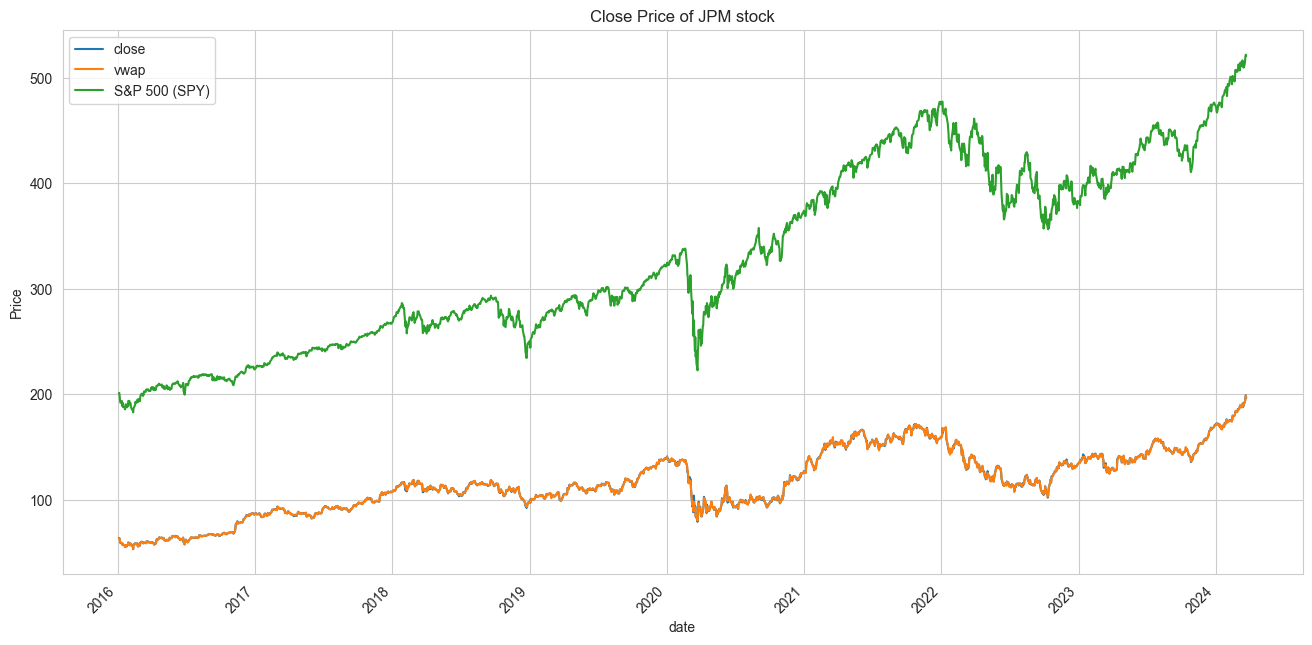

In [317]:
plt.figure(figsize=(16,8))
df['close'].plot(kind='line')
df['vwap'].plot(kind='line')
df_spy['close'].plot(kind='line', label='S&P 500 (SPY)')
plt.xticks(rotation = 45)
plt.title('Close Price of JPM stock')
plt.ylabel('Price')
plt.legend()
plt.show()


##### The 'vwap' is a feature variable which is an independent, and 'close' price is the target, which is a dependent variable (explainable).  

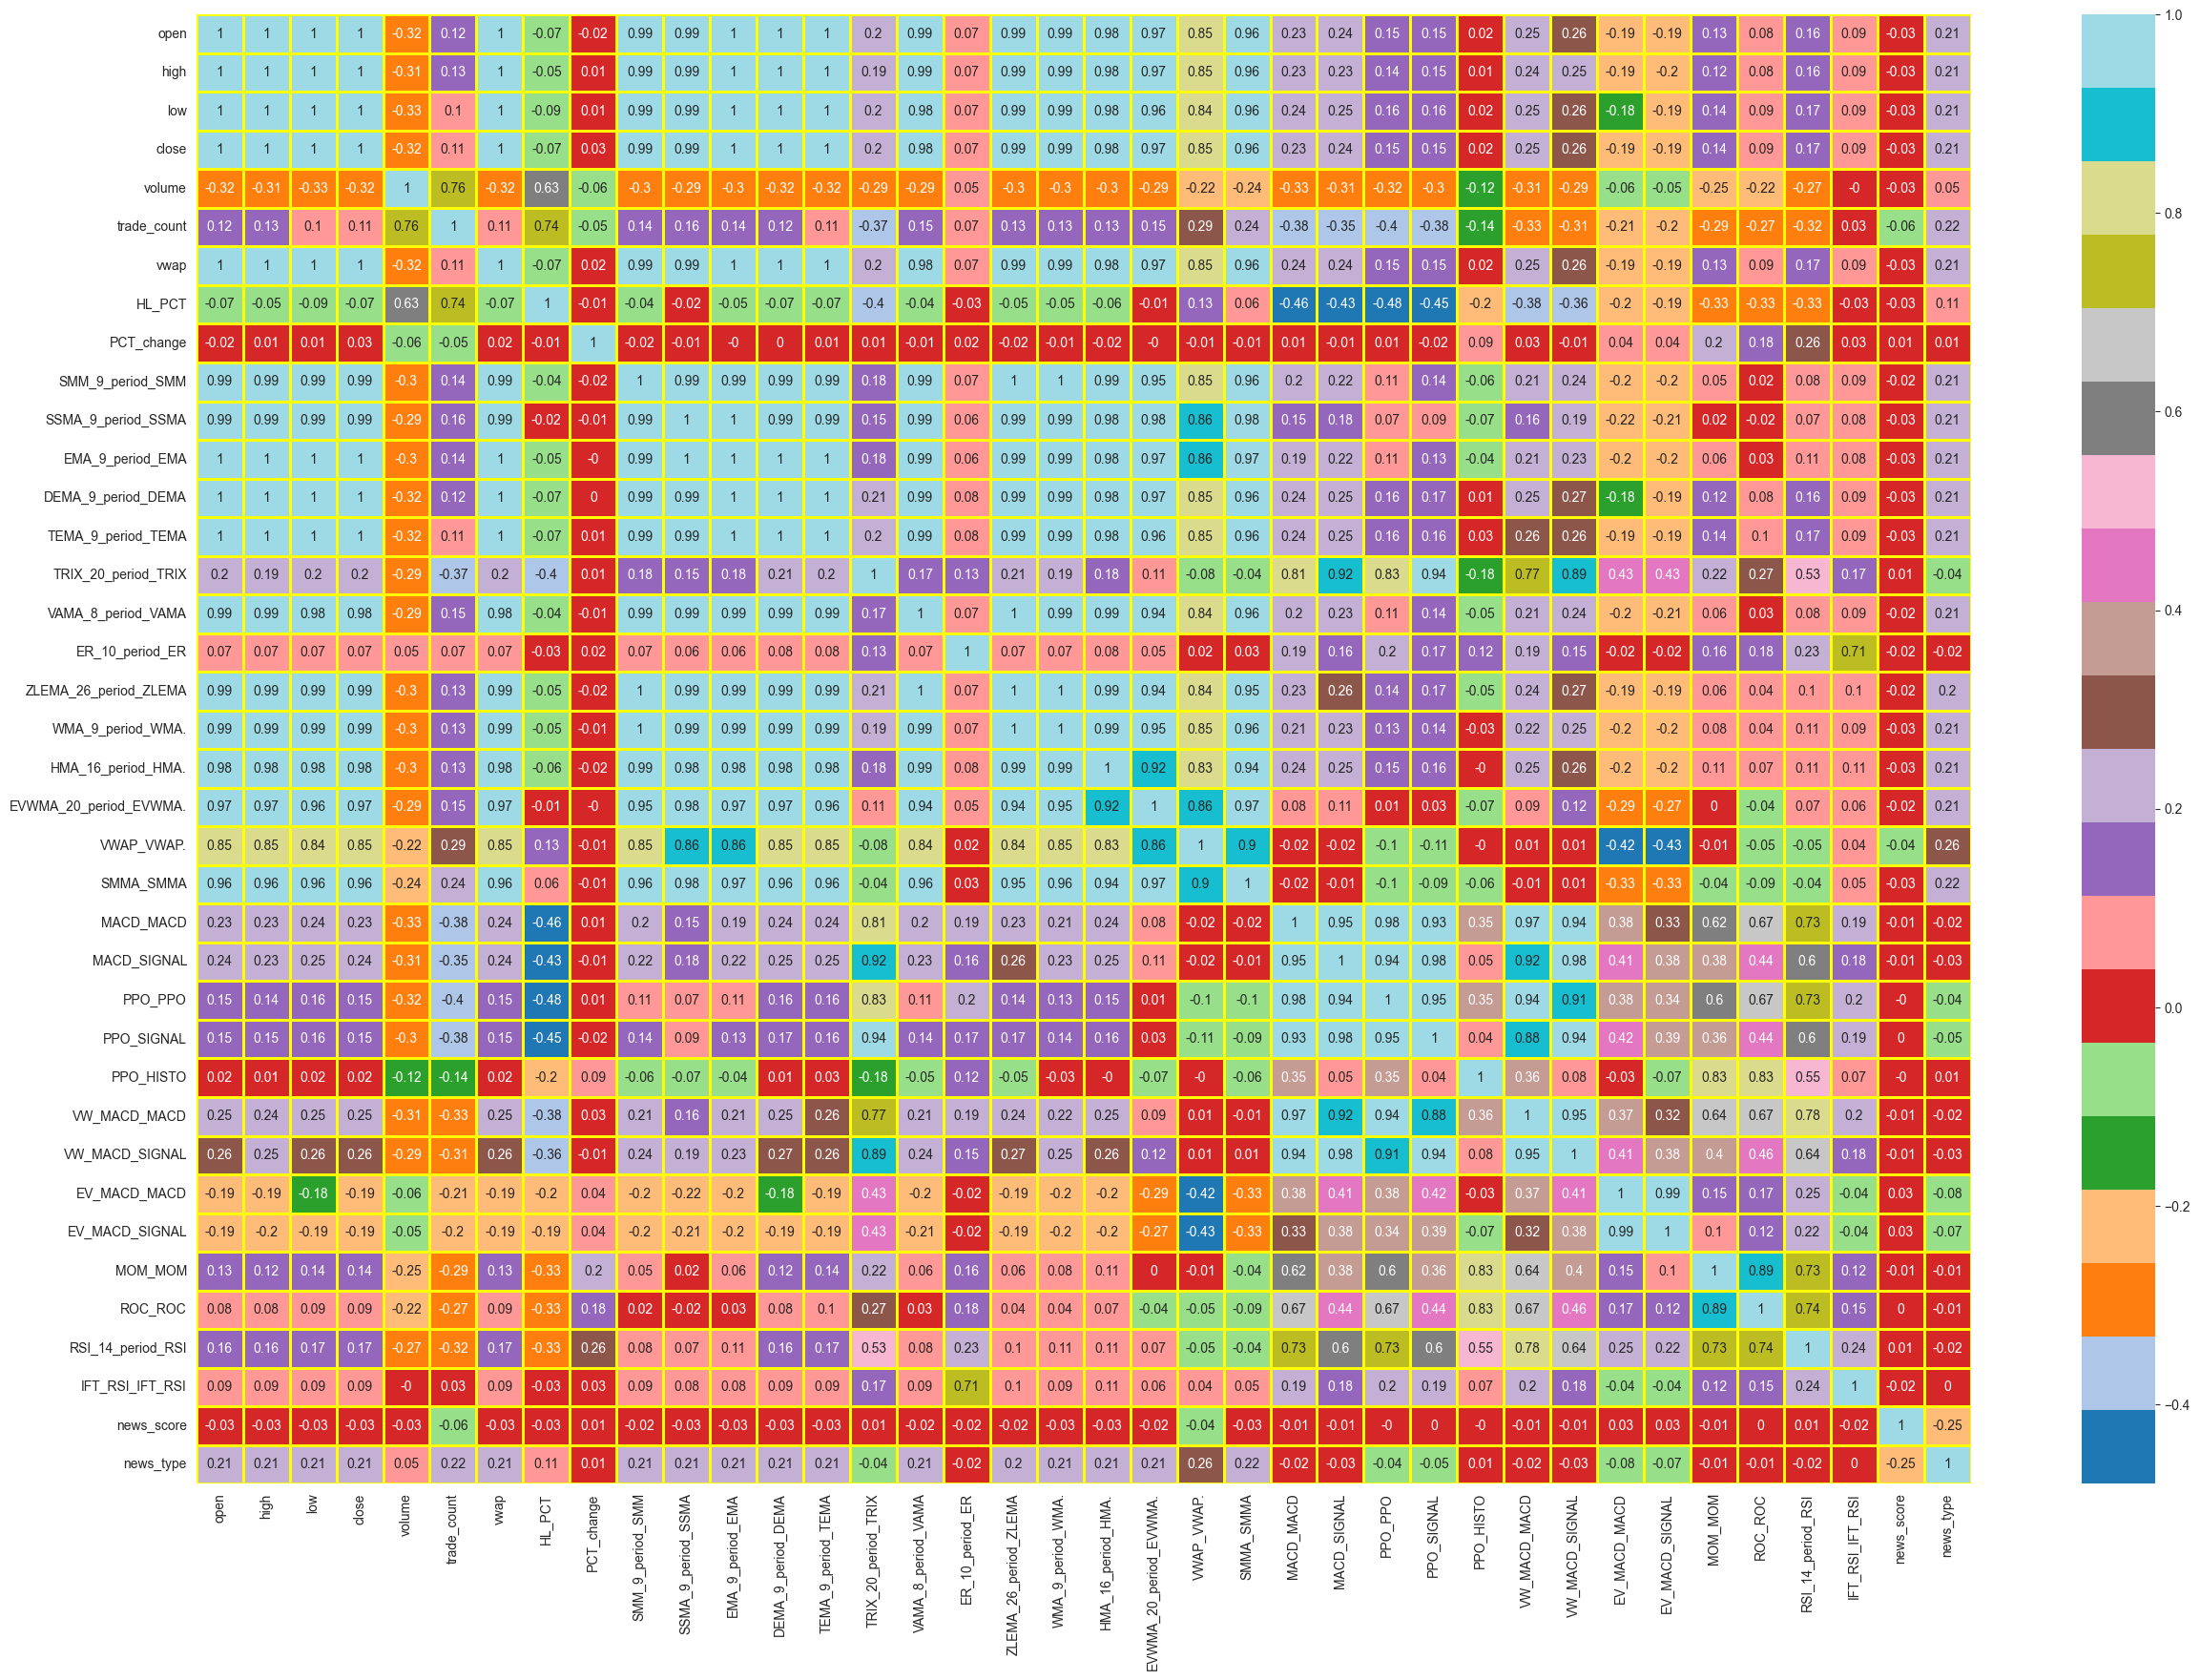

In [318]:
corr =df.corr()
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [319]:
corr_matrix = pd.DataFrame(corr)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

#### Removing highly correlated features, and to the 'close' price, which is the target feature

In [320]:
corr_matrix['close'].sort_values(ascending=False).to_frame().index

Index(['open', 'TEMA_9_period_TEMA', 'low', 'close', 'high', 'vwap',
       'EMA_9_period_EMA', 'DEMA_9_period_DEMA', 'WMA_9_period_WMA.',
       'ZLEMA_26_period_ZLEMA', 'SMM_9_period_SMM', 'SSMA_9_period_SSMA',
       'VAMA_8_period_VAMA', 'HMA_16_period_HMA.', 'EVWMA_20_period_EVWMA.',
       'SMMA_SMMA', 'VWAP_VWAP.', 'VW_MACD_SIGNAL', 'VW_MACD_MACD',
       'MACD_SIGNAL', 'MACD_MACD', 'news_type', 'TRIX_20_period_TRIX',
       'RSI_14_period_RSI', 'PPO_PPO', 'PPO_SIGNAL', 'MOM_MOM', 'trade_count',
       'ROC_ROC', 'IFT_RSI_IFT_RSI', 'ER_10_period_ER', 'PCT_change',
       'PPO_HISTO', 'news_score', 'HL_PCT', 'EV_MACD_MACD', 'EV_MACD_SIGNAL',
       'volume'],
      dtype='object')

In [321]:
low_corr_columns = ['close', 'news_type', 'MACD_MACD',  # 'VWAP_VWAP.'
                    'TRIX_20_period_TRIX', 'RSI_14_period_RSI', 'news_score', 'PPO_PPO',
                    'trade_count', 'MOM_MOM', 'ROC_ROC', 'IFT_RSI_IFT_RSI',
                    'ER_10_period_ER', 'PCT_change', 'PPO_HISTO', 'HL_PCT', 'EV_MACD_MACD', 'EV_MACD_SIGNAL', 'volume'] 

In [322]:
df_corr  = df[low_corr_columns]

<Axes: >

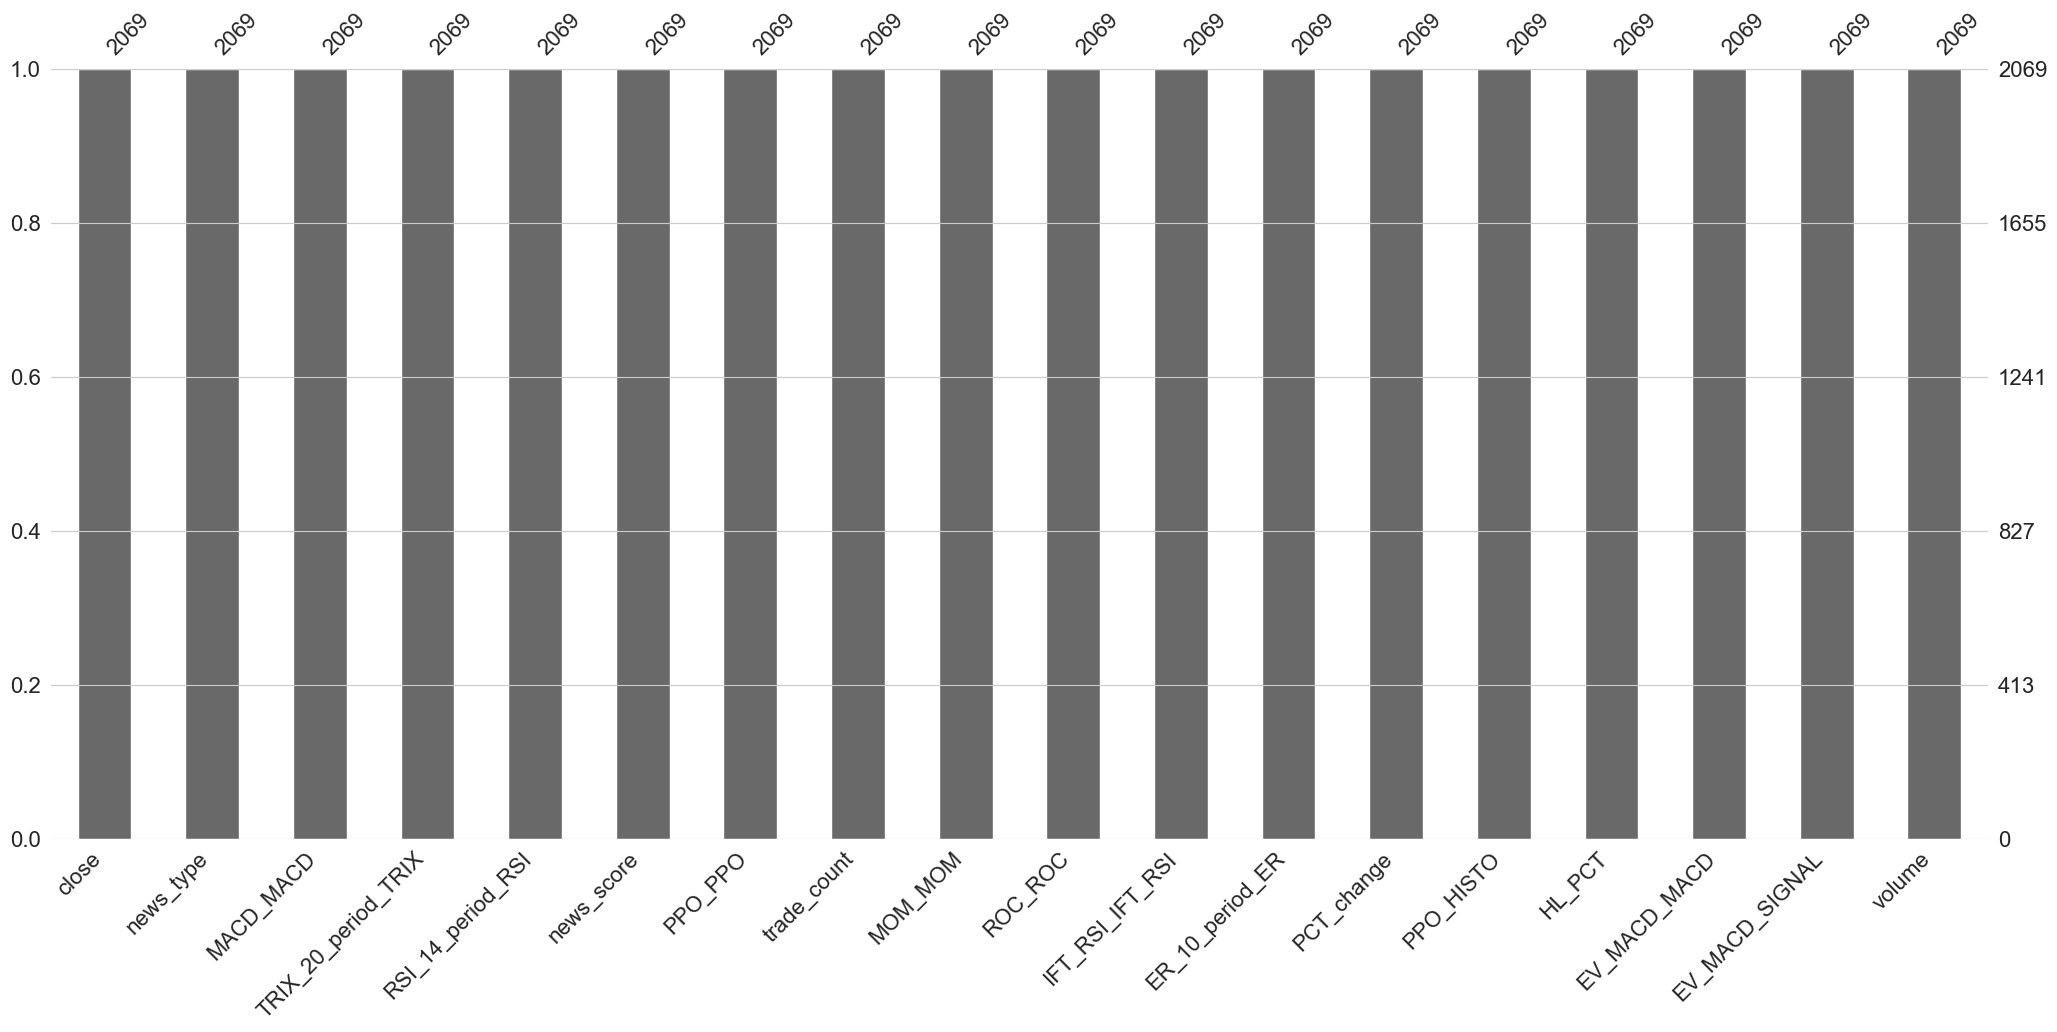

In [323]:
msno.bar(df_corr)

In [324]:
df_corr.tail()

close  news_type  MACD_MACD  TRIX_20_period_TRIX  \
date                                                            
2024-03-18  192.66          1   3.806380             0.283707   
2024-03-19  193.79          1   3.936580             0.285985   
2024-03-20  196.33          2   4.196349             0.289581   
2024-03-21  199.06          1   4.569828             0.295091   
2024-03-22  196.62          1   4.615718             0.300396   

            RSI_14_period_RSI  news_score   PPO_PPO  trade_count  MOM_MOM  \
date                                                                        
2024-03-18          71.649835    0.999485  2.059540     109669.0     5.98   
2024-03-19          73.264812    0.999417  2.122356     103994.0     5.24   
2024-03-20          76.504711    0.794103  2.252647     129684.0     6.80   
2024-03-21          79.394961    0.999364  2.440737     139164.0    11.19   
2024-03-22          70.989517    0.994834  2.456123     109826.0     8.40   

             ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  PCT_change  PPO_HISTO  \
date                                                                            
2024-03-18  3.547243         0.539965         0.370968    1.064890  -0.018563   
2024-03-19  4.587404         0.574232         0.340702    0.560428   0.035402   
2024-03-20  5.169274         0.652196         0.401417    1.102013   0.132555   
2024-03-21  5.574118         0.723550         0.621321    1.292489   0.256515   
2024-03-22  3.740833         0.698854         0.417910   -1.200945   0.217522   

              HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL      volume  
date                                                            
2024-03-18  1.458528      8.926550        8.452037   9013843.0  
2024-03-19  0.799835      9.023703        8.566371   8478717.0  
2024-03-20  1.502572      9.176131        8.688323   9367043.0  
2024-03-21  1.557319      9.411702        8.832998  11203796.0  
2024-03-22  2.003865      9.482224        8.962843   8108840.0

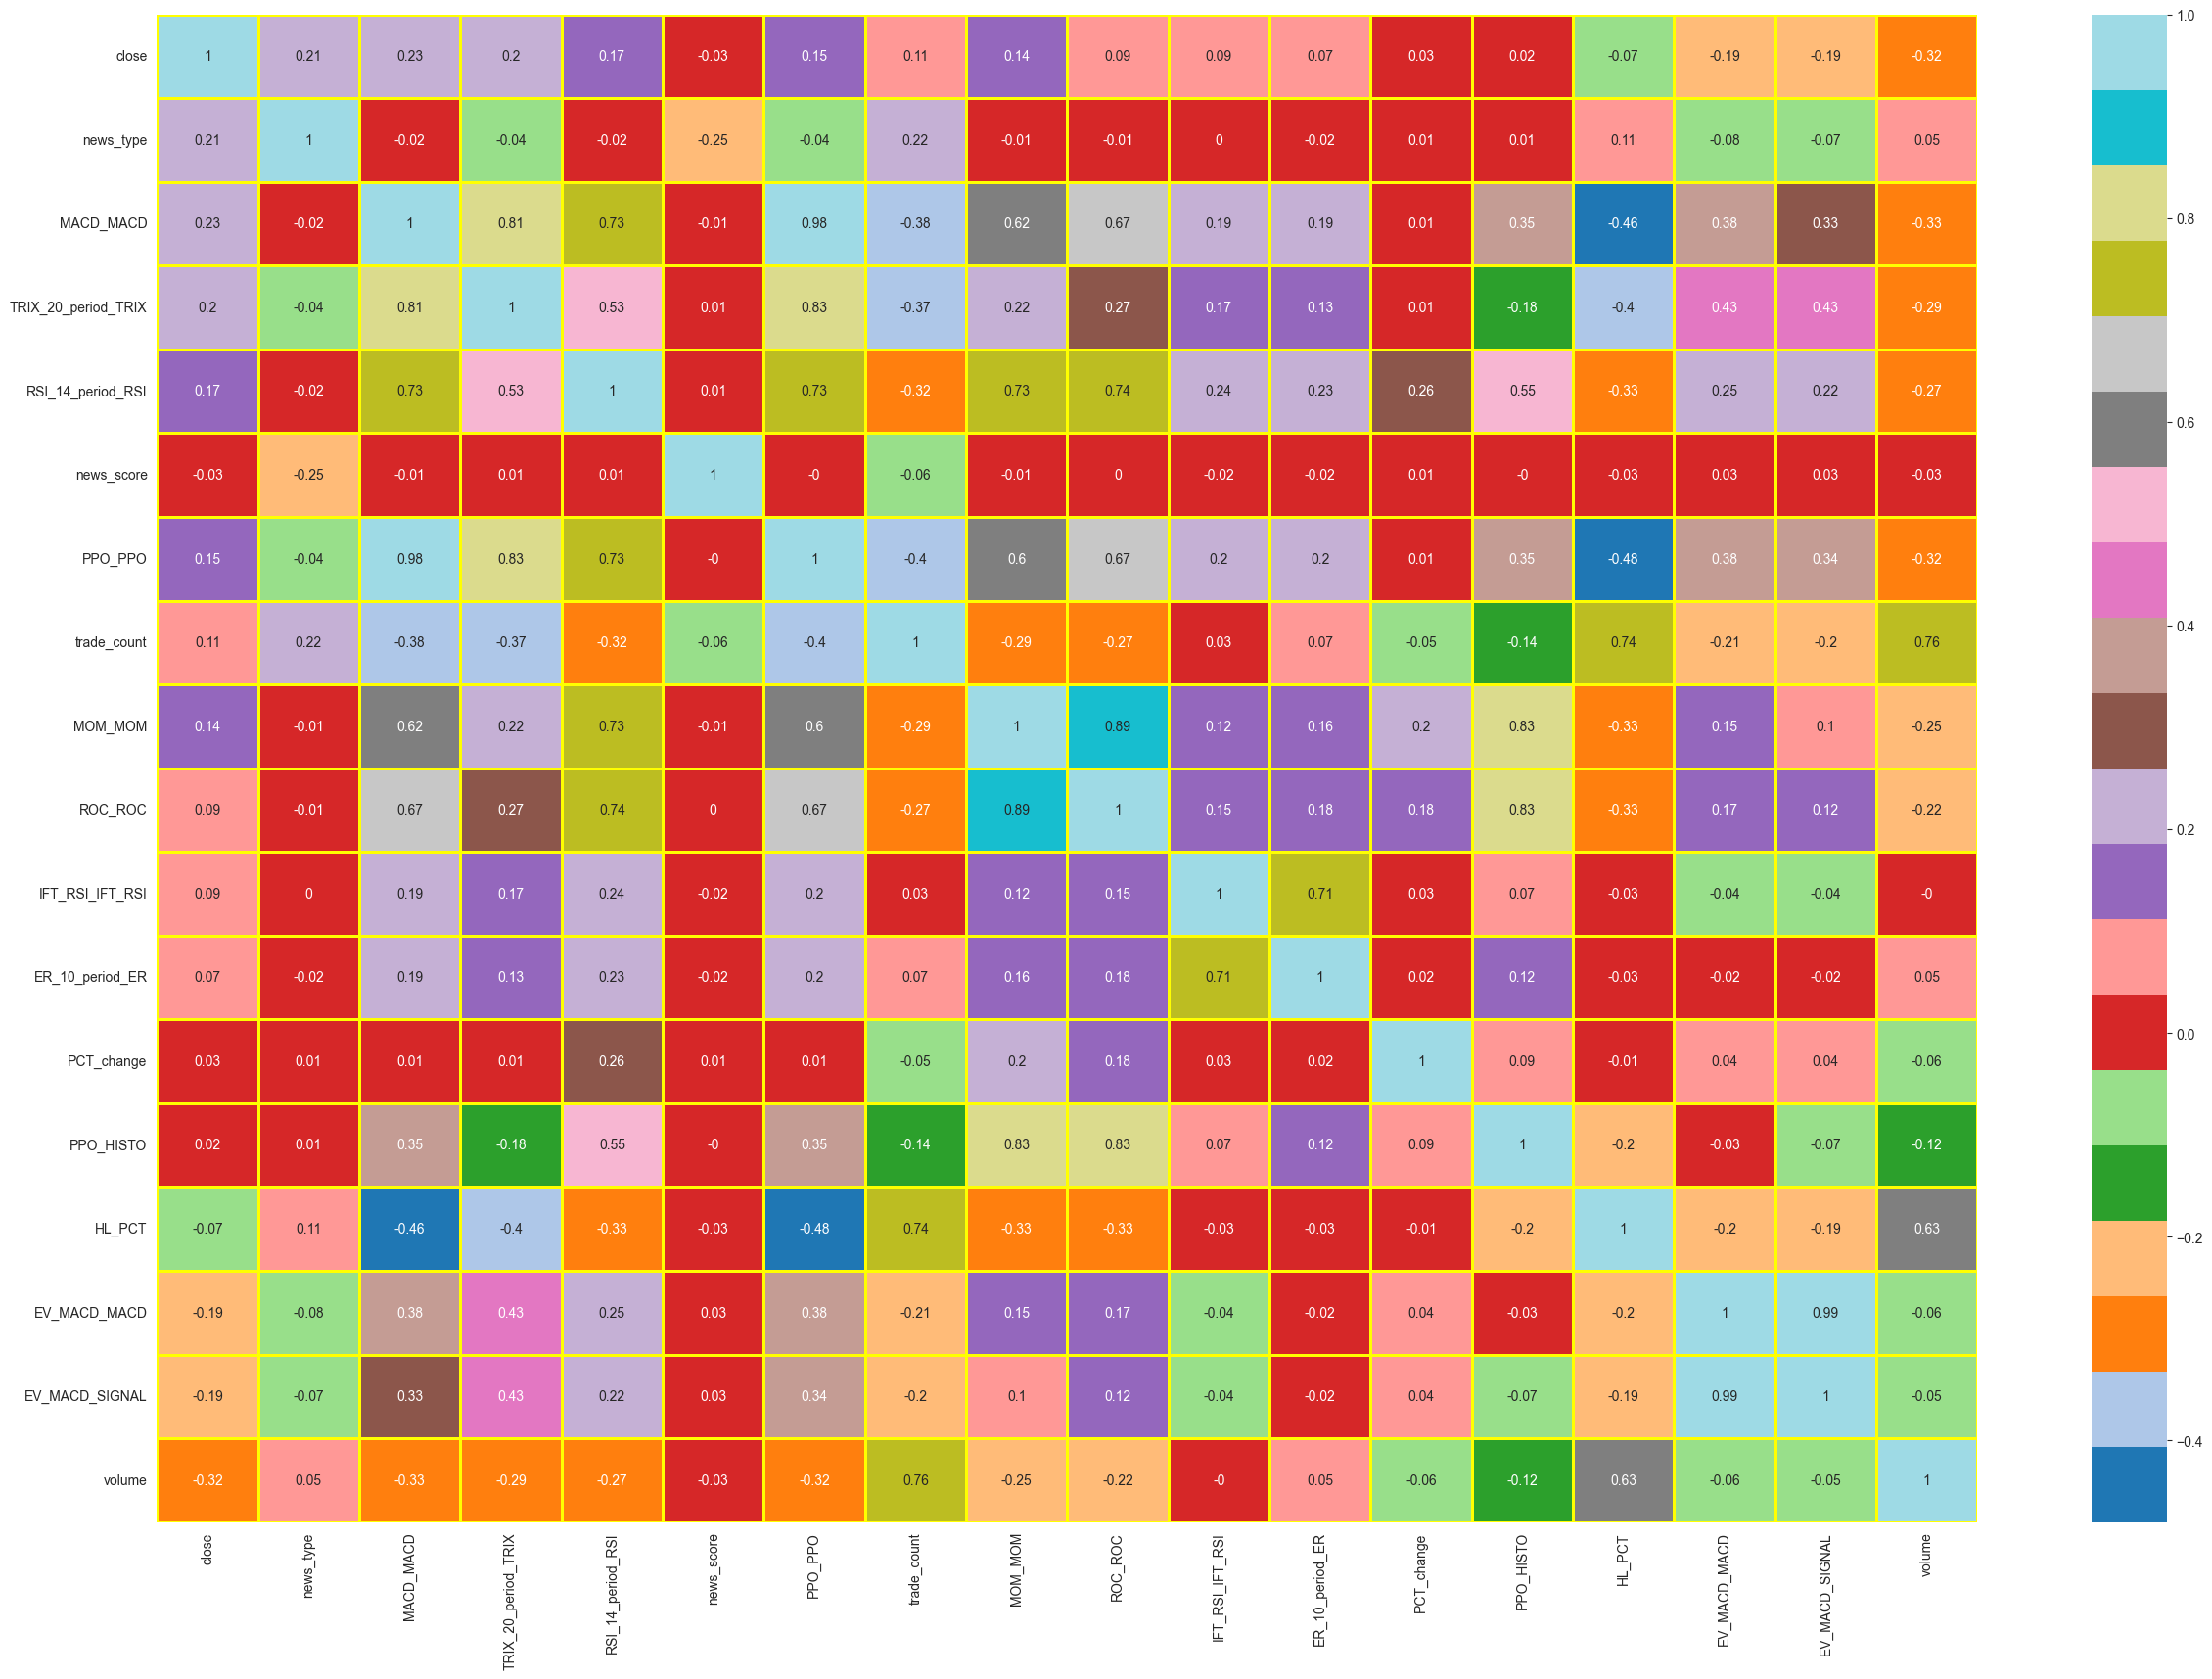

In [325]:
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
corr_low =df_corr.corr()
sns.heatmap(corr_low.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [326]:
# Correlations to the Target feature 'close'
corr_matrix = pd.DataFrame(corr_low)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

In [327]:
df_corr.describe()

close    news_type    MACD_MACD  TRIX_20_period_TRIX  \
count  2069.000000  2069.000000  2069.000000          2069.000000   
mean    116.314079     1.176414     0.423261             0.049668   
std      30.272007     0.396191     2.138606             0.216897   
min      53.070000     0.000000   -12.509386            -1.037542   
25%      96.450000     1.000000    -0.620077            -0.069407   
50%     113.860000     1.000000     0.484338             0.068483   
75%     139.130000     1.000000     1.645059             0.173369   
max     199.060000     2.000000     5.649333             0.531040   

       RSI_14_period_RSI   news_score      PPO_PPO    trade_count  \
count        2069.000000  2069.000000  2069.000000    2069.000000   
mean           53.917886     0.988957     0.355462  114038.200097   
std            12.701765     0.045470     1.811485   52974.268721   
min             1.879140     0.427321   -11.864494       1.000000   
25%            45.383535     0.994834    -0.558119   79655.000000   
50%            53.514654     0.999258     0.520805  102172.000000   
75%            63.180606     0.999452     1.395903  131260.000000   
max           100.000000     0.999706     4.806173  457367.000000   

           MOM_MOM      ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  \
count  2069.000000  2069.000000      2069.000000      2069.000000   
mean      0.645249     0.852853         0.057659         0.343531   
std       6.111039     5.655454         0.608590         0.232506   
min     -38.720000   -32.038694        -1.000000         0.000000   
25%      -2.160000    -2.127025        -0.478723         0.148225   
50%       0.850000     1.036384         0.208088         0.312839   
75%       4.060000     3.938293         0.609456         0.509048   
max      23.980000    25.442653         0.891388         1.000000   

        PCT_change    PPO_HISTO       HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL  \
count  2069.000000  2069.000000  2069.000000   2069.000000     2069.000000   
mean      0.026984     0.004703     1.897712      2.472903        2.455749   
std       1.247398     0.554120     1.172306      5.982440        5.909170   
min      -5.234433    -3.149239     0.411324     -7.789779       -7.692935   
25%      -0.599933    -0.291993     1.183146     -0.133768       -0.072236   
50%       0.052333    -0.000199     1.609756      1.683519        1.653009   
75%       0.671395     0.291192     2.259144      4.265796        4.169705   
max       8.250859     2.693997    13.130129     35.513405       33.707684   

             volume  
count  2.069000e+03  
mean   1.552134e+07  
std    7.411377e+06  
min    1.604000e+05  
25%    1.071221e+07  
50%    1.398421e+07  
75%    1.789607e+07  
max    7.290765e+07

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'news_type'}>,
        <Axes: title={'center': 'MACD_MACD'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'news_score'}>,
        <Axes: title={'center': 'PPO_PPO'}>,
        <Axes: title={'center': 'trade_count'}>],
       [<Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>],
       [<Axes: title={'center': 'PCT_change'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'HL_PCT'}>,
        <Axes: title={'center': 'EV_MACD_MACD'}>],
       [<Axes: title={'center': 'EV_MACD_SIGNAL'}>,
        <Axes: title={'center': 'volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

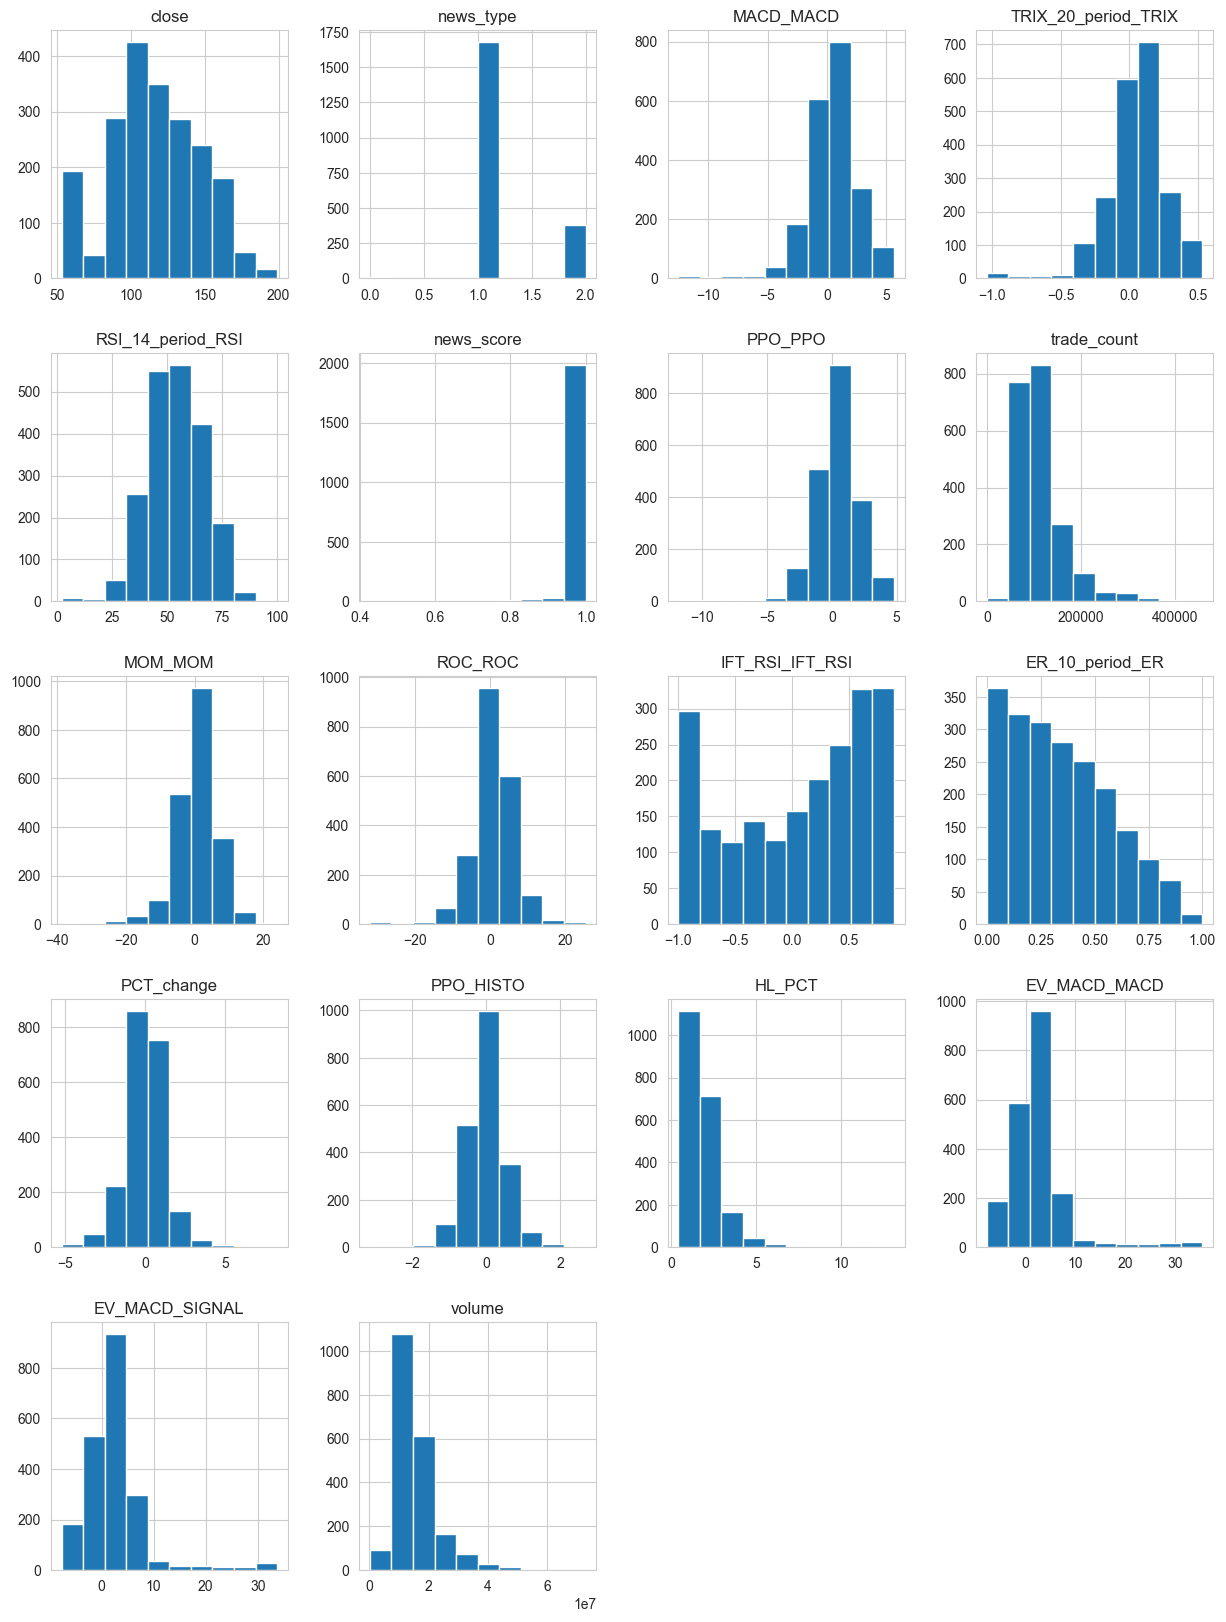

In [328]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_corr.hist(ax=ax)

##### from the dataframe describe mean and std are not 0 and 1, and from the histogram we can see the dataset is skewed on left and right
##### even the 'vwap' feature is highly correlated to the target, it is kept. The "Volume Weighted Average Price" is a benchmark indicator for traders

In [329]:
#Scaling dataset before Normalising it
data = df_corr.copy()
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df_corr)
df_norm = pd.DataFrame(trans_array)
named_columns = df_corr.columns
numer_columns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_columns, named_columns))]
columns = dict(tuples)
df_norm.rename(columns=columns, inplace=True)
df_norm = df_norm[named_columns]
df_norm.index = df.index
df_norm.describe()

close    news_type    MACD_MACD  TRIX_20_period_TRIX  \
count  2069.000000  2069.000000  2069.000000          2069.000000   
mean     -0.000090     0.735418     0.000117            -0.000142   
std       1.008992     2.141186     1.009732             1.009637   
min      -5.199338    -5.199338    -5.199338            -5.199338   
25%      -0.674987    -0.223916    -0.674262            -0.673882   
50%      -0.000217    -0.223916     0.000541            -0.000020   
75%       0.674140    -0.223916     0.673717             0.673754   
max       5.199338     5.199338     5.199338             5.199338   

       RSI_14_period_RSI   news_score      PPO_PPO  trade_count      MOM_MOM  \
count        2069.000000  2069.000000  2069.000000  2069.000000  2069.000000   
mean           -0.000410     0.010120     0.000105    -0.000596    -0.000037   
std             1.010471     0.989156     1.009595     1.011188     1.009351   
min            -5.199338    -5.199338    -5.199338    -5.199338    -5.199338   
25%            -0.674480    -0.691121    -0.674002    -0.673785    -0.673702   
50%            -0.000013    -0.000179    -0.000750    -0.000626     0.000000   
75%             0.675768     0.673949     0.674066     0.674047     0.676854   
max             5.199338     5.199338     5.199338     5.199338     5.199338   

           ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER   PCT_change  \
count  2069.000000      2069.000000      2069.000000  2069.000000   
mean      0.000026        -0.000414        -0.000091     0.000105   
std       1.009449         1.010490         1.009557     1.009454   
min      -5.199338        -5.199338        -5.199338    -5.199338   
25%      -0.674659        -0.674647        -0.675231    -0.673930   
50%       0.000000         0.000000         0.000000    -0.000756   
75%       0.675432         0.674528         0.673799     0.674417   
max       5.199338         5.199338         5.199338     5.199338   

         PPO_HISTO       HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL       volume  
count  2069.000000  2069.000000   2069.000000     2069.000000  2069.000000  
mean     -0.000064    -0.000067      0.000019        0.000062    -0.000076  
std       1.009313     1.009299      1.009655        1.009577     1.009151  
min      -5.199338    -5.199338     -5.199338       -5.199338    -5.199338  
25%      -0.676653    -0.674925     -0.674579       -0.673862    -0.673826  
50%       0.000944    -0.000242     -0.001203       -0.000574    -0.000403  
75%       0.673811     0.674392      0.674831        0.674232     0.675411  
max       5.199338     5.199338      5.199338        5.199338     5.199338

array([[<Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'news_type'}>,
        <Axes: title={'center': 'MACD_MACD'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>],
       [<Axes: title={'center': 'RSI_14_period_RSI'}>,
        <Axes: title={'center': 'news_score'}>,
        <Axes: title={'center': 'PPO_PPO'}>,
        <Axes: title={'center': 'trade_count'}>],
       [<Axes: title={'center': 'MOM_MOM'}>,
        <Axes: title={'center': 'ROC_ROC'}>,
        <Axes: title={'center': 'IFT_RSI_IFT_RSI'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>],
       [<Axes: title={'center': 'PCT_change'}>,
        <Axes: title={'center': 'PPO_HISTO'}>,
        <Axes: title={'center': 'HL_PCT'}>,
        <Axes: title={'center': 'EV_MACD_MACD'}>],
       [<Axes: title={'center': 'EV_MACD_SIGNAL'}>,
        <Axes: title={'center': 'volume'}>, <Axes: >, <Axes: >]],
      dtype=object)

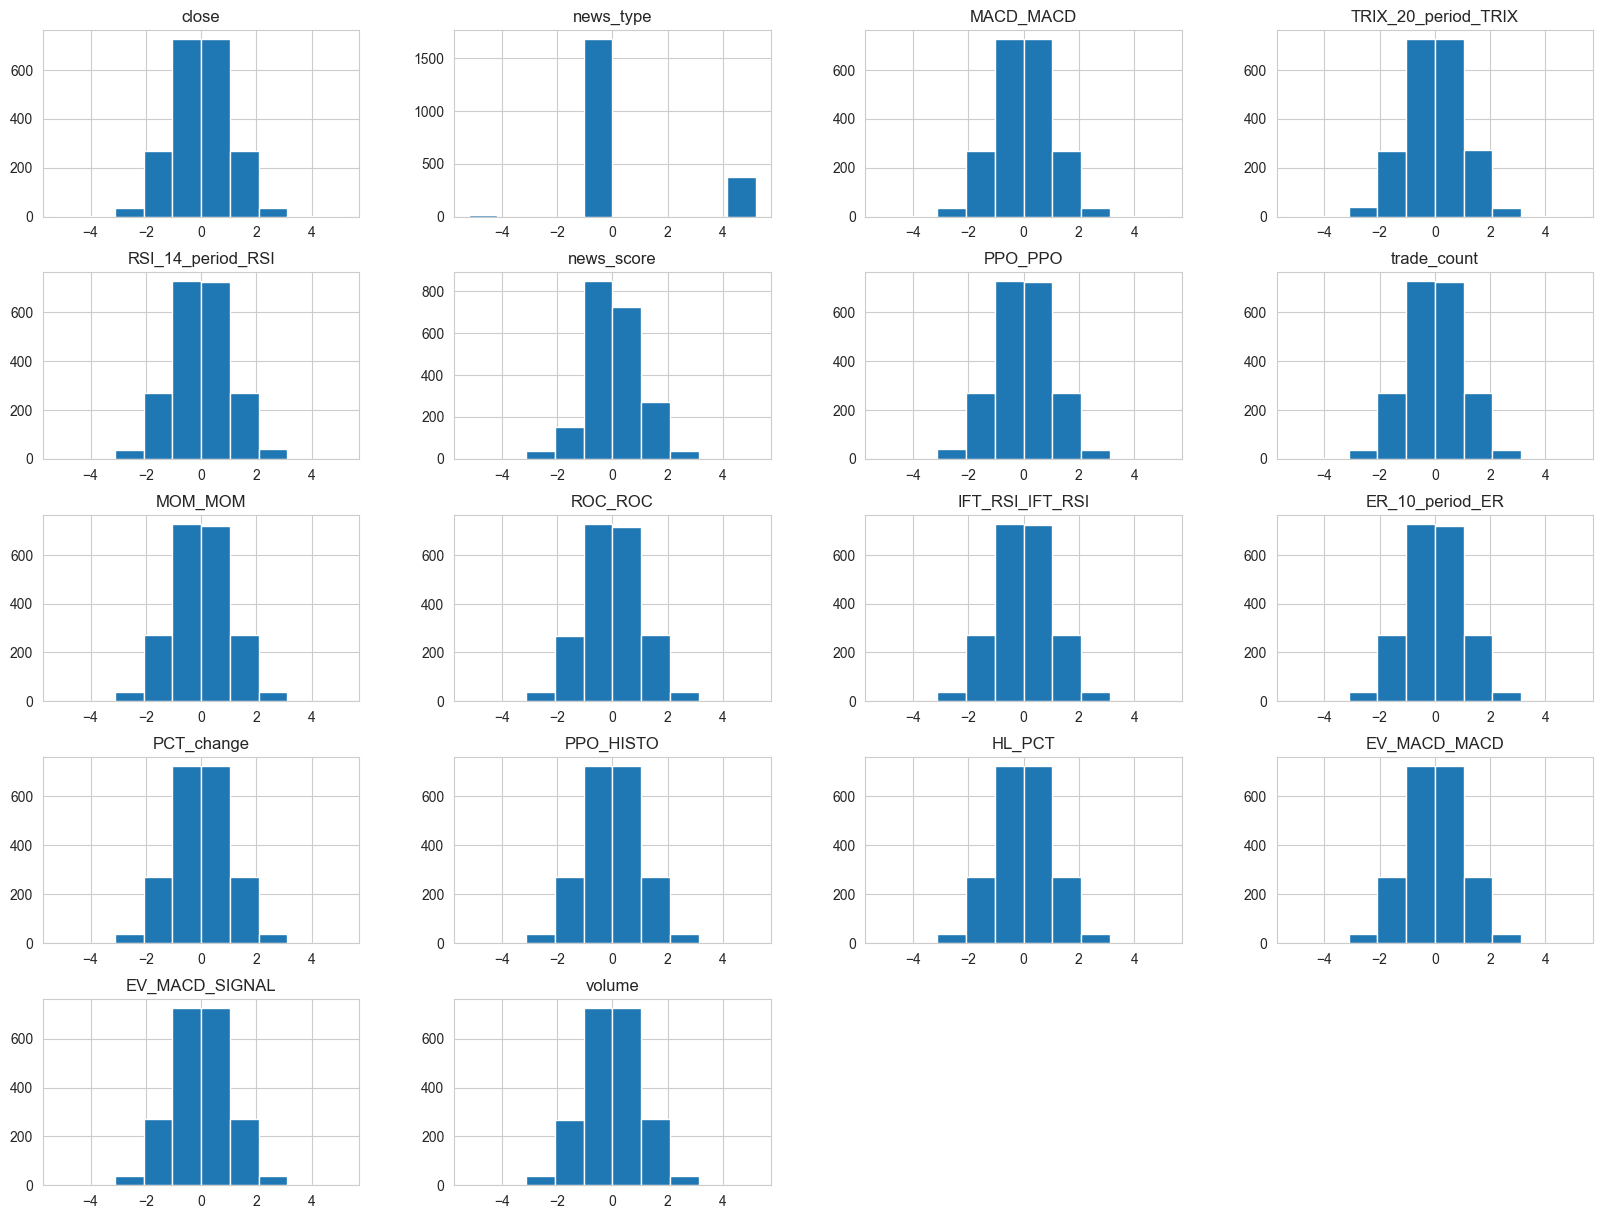

In [330]:
df_norm.hist(figsize=(20,15))

##### As we can see from the describe method of pandas DataFrame, the mean is 0 and std is 1 and from the above bell shape plots, now our dataset has a normal distribution

In [331]:
df_norm.tail()

close  news_type  MACD_MACD  TRIX_20_period_TRIX  \
date                                                              
2024-03-18  2.885640  -0.223916   1.615518             1.247011   
2024-03-19  2.939257  -0.223916   1.652090             1.259107   
2024-03-20  3.108645   5.199338   1.778194             1.268857   
2024-03-21  5.199338  -0.223916   2.034126             1.296077   
2024-03-22  3.141679  -0.223916   2.078966             1.315255   

            RSI_14_period_RSI  news_score   PPO_PPO  trade_count   MOM_MOM  \
date                                                                         
2024-03-18           1.371581    1.326651  1.121633     0.203390  1.010242   
2024-03-19           1.531115    0.309940  1.163606     0.046881  0.863942   
2024-03-20           1.829435   -2.211406  1.279009     0.645952  1.158450   
2024-03-21           2.196769    0.098515  1.365384     0.814246  1.878977   
2024-03-22           1.304725   -0.691121  1.377141     0.207585  1.397837   

             ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  PCT_change  PPO_HISTO  \
date                                                                            
2024-03-18  0.589505         0.526222         0.200510    1.053782  -0.044681   
2024-03-19  0.791871         0.581475         0.106631    0.562423   0.087328   
2024-03-20  0.902911         0.816035         0.309894    1.101187   0.310121   
2024-03-21  0.965519         1.070744         1.061255    1.257871   0.603823   
2024-03-22  0.632388         0.985624         0.368051   -1.112069   0.498419   

              HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL    volume  
date                                                          
2024-03-18 -0.206465      1.556136        1.525933 -1.177218  
2024-03-19 -1.663061      1.563448        1.534616 -1.349610  
2024-03-20 -0.146796      1.575701        1.546420 -1.048415  
2024-03-21 -0.072364      1.588563        1.557921 -0.552293  
2024-03-22  0.449679      1.594543        1.571379 -1.485840

In [332]:
df_norm.head()

close  news_type  MACD_MACD  TRIX_20_period_TRIX  \
date                                                              
2016-01-04 -1.611704  -0.223916  -0.333648            -0.000020   
2016-01-05 -1.596999  -0.223916  -0.330835            -0.231099   
2016-01-06 -1.671682  -0.223916  -0.353763            -0.585882   
2016-01-07 -1.844349  -0.223916  -0.415392            -1.176231   
2016-01-08 -2.053336  -0.223916  -0.479470            -1.451699   

            RSI_14_period_RSI  news_score   PPO_PPO  trade_count  MOM_MOM  \
date                                                                        
2016-01-04          -0.000013    0.021495 -0.333654     0.931895      0.0   
2016-01-05           5.199338    0.283745 -0.330781     0.024479      0.0   
2016-01-06          -2.769435    0.027310 -0.360275     0.540137      0.0   
2016-01-07          -3.108228    1.388671 -0.455586     1.195085      0.0   
2016-01-08          -3.918793    0.851675 -0.572288     0.747983      0.0   

            ROC_ROC  IFT_RSI_IFT_RSI  ER_10_period_ER  PCT_change  PPO_HISTO  \
date                                                                           
2016-01-04      0.0              0.0              0.0   -0.590908   0.001472   
2016-01-05      0.0              0.0              0.0    0.015773   0.006065   
2016-01-06      0.0              0.0              0.0    0.146340  -0.060622   
2016-01-07      0.0              0.0              0.0   -1.644495  -0.276874   
2016-01-08      0.0              0.0              0.0   -2.510699  -0.470758   

              HL_PCT  EV_MACD_MACD  EV_MACD_SIGNAL    volume  
date                                                          
2016-01-04  0.058748     -0.613509       -0.621099  1.528145  
2016-01-05  0.127337     -0.613509       -0.621099  0.615970  
2016-01-06 -0.535578     -0.613509       -0.621099  1.300732  
2016-01-07  1.347533     -0.613509       -0.621099  1.581606  
2016-01-08  1.765787     -0.613509       -0.621099  1.321225

### Modeling

In [333]:
X = df.drop(columns=['close'], axis=1)
y = df['close']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=42)

X_corr = df_corr.drop(columns=['close'], axis=1)
y_corr = df_corr['close']
X_corr_train, X_corr_val, y_corr_train, y_corr_val = train_test_split(X_corr, y_corr, test_size=0.33, random_state=42)

X_norm = df_norm.drop(columns=['close'], axis=1)
y_norm = df_norm['close']
X_norm_train, X_norm_val, y_norm_train, y_norm_val = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)

In [334]:
X_val.sort_index(inplace=True)
X_train.sort_index(inplace=True)
X_corr_val.sort_index(inplace=True)
X_corr_train.sort_index(inplace=True)
X_norm_val.sort_index(inplace=True)
X_norm_train.sort_index(inplace=True)

In [335]:
y_val.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_corr_val.sort_index(inplace=True)
y_corr_train.sort_index(inplace=True)
y_norm_val.sort_index(inplace=True)
y_norm_train.sort_index(inplace=True)

### Regression  Baseline Model using normalized data

In [336]:
complexity = 5
complex_index_norm = get_complexity(X_norm_train, X_norm_val, y_norm_train, y_norm_val, complexity)
poly_ordinal_norm = make_column_transformer((PolynomialFeatures(include_bias=False, degree=complex_index_norm), make_column_selector(dtype_include=np.number)))

The best degree of the polynomial model is:  1 out of 5
The smallest mean squared error on the test dataset is :  0.3612 out of [0.3612, 0.3939, 6.595457222646441e+19, 26.789, 98.9213]
The best value of the R-sq of the model, as a good fit is:  0.6245 out of [0.6245, 0.5905, -6.857400750265091e+19, -26.8529, -101.85]


In [337]:
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge = Pipeline([('transformer', poly_ordinal_norm), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge.fit(X_norm_train, y_norm_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(degree=1,
                                                                     include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023B1B5AD3C0>)])),
                ('scaler', StandardScaler()),
                ('ridgereg', RidgeCV(alphas=[0.001, 0.1, 1.0, 10.0, 100.0]))])

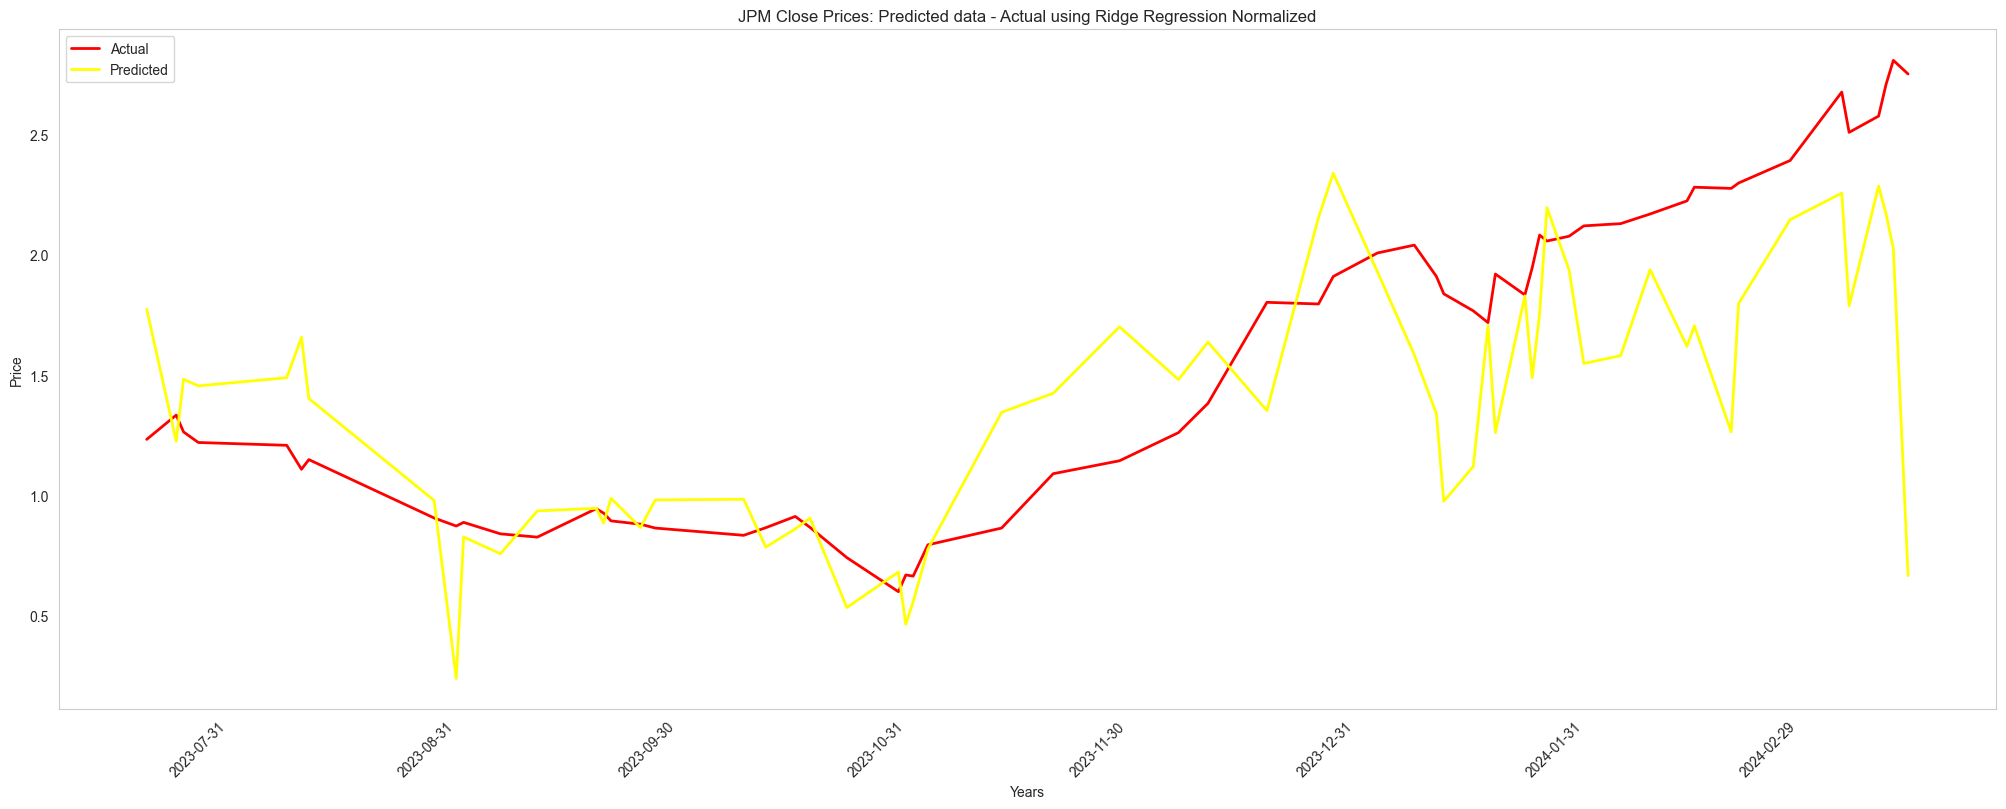

In [338]:
regression_model = {'Ridge Regression Normalized': ridge }
reg_model_metrics(regression_model, X_norm_train, X_norm_val, y_norm_train, y_norm_val)

In [339]:
print_permutation_importance([(ridge,'ridgereg')], X_norm_val, y_norm_val, df_norm, X_norm)

Permutation importance to Close for RidgeCV
PPO_PPO           1.527 +/- 0.089
trade_count       1.267 +/- 0.062
volume            1.169 +/- 0.036
MACD_MACD         0.681 +/- 0.043
EV_MACD_MACD      0.633 +/- 0.034
TRIX_20_period_TRIX0.509 +/- 0.037
EV_MACD_SIGNAL    0.226 +/- 0.019
RSI_14_period_RSI 0.022 +/- 0.007
HL_PCT            0.014 +/- 0.004
PPO_HISTO         0.008 +/- 0.005
MOM_MOM           0.003 +/- 0.003
news_type         0.002 +/- 0.003
ROC_ROC           0.002 +/- 0.001
PCT_change        0.000 +/- 0.001
IFT_RSI_IFT_RSI   0.000 +/- 0.000
news_score        -0.000 +/- 0.001
ER_10_period_ER   -0.000 +/- 0.000
 


### Regression Models

In [340]:
poly_degree = get_complexity(X_corr_train, X_corr_val, y_corr_train, y_corr_val, complexity)
poly_ordinal = make_column_transformer((PolynomialFeatures(include_bias=False, degree=poly_degree), make_column_selector(dtype_include=np.number)))

The best degree of the polynomial model is:  2 out of 5
The smallest mean squared error on the test dataset is :  297.1791 out of [347.5853, 297.1791, 594.5056, 2365.7988, 4461.983]
The best value of the R-sq of the model, as a good fit is:  0.6646 out of [0.6077, 0.6646, 0.329, -1.6702, -4.0361]


In [341]:
linreg = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_corr_train, y_corr_train)

alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge1.fit(X_corr_train, y_corr_train)

lasso = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('lasso_reg', Lasso(alpha=0.01, random_state=42))])
lasso.fit(X_corr_train, y_corr_train)

param_grid = {
    'clf__alpha': [0.1, 1, 10, 0.01],
    'clf__tol': [0.0001, 0.001]
}
pipeline_grid = Pipeline([('transformer', poly_ordinal), ('scaler', MinMaxScaler()), ('clf', HuberRegressor(max_iter=5000))])
grid_search = GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_corr_train, y_corr_train)

rfr = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(random_state=0))])
rfr.fit(X_corr_train, y_corr_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000023B1B632A70>)])),
                ('scaler', StandardScaler()),
                ('rfr', RandomForestRegressor(random_state=0))])

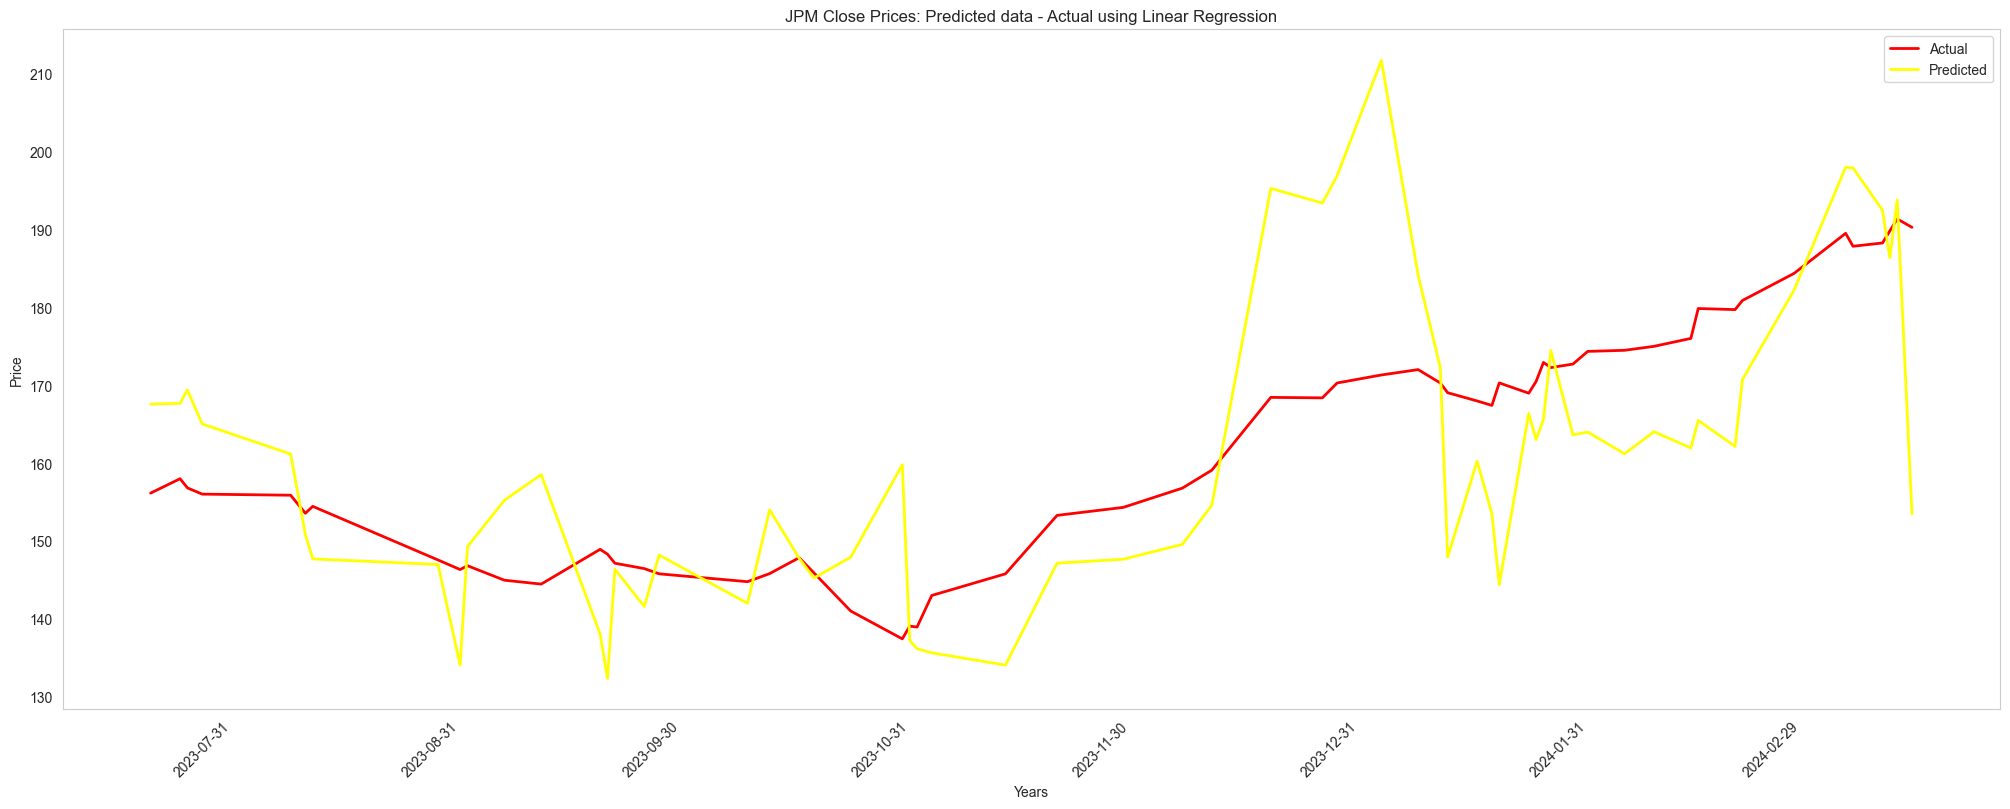

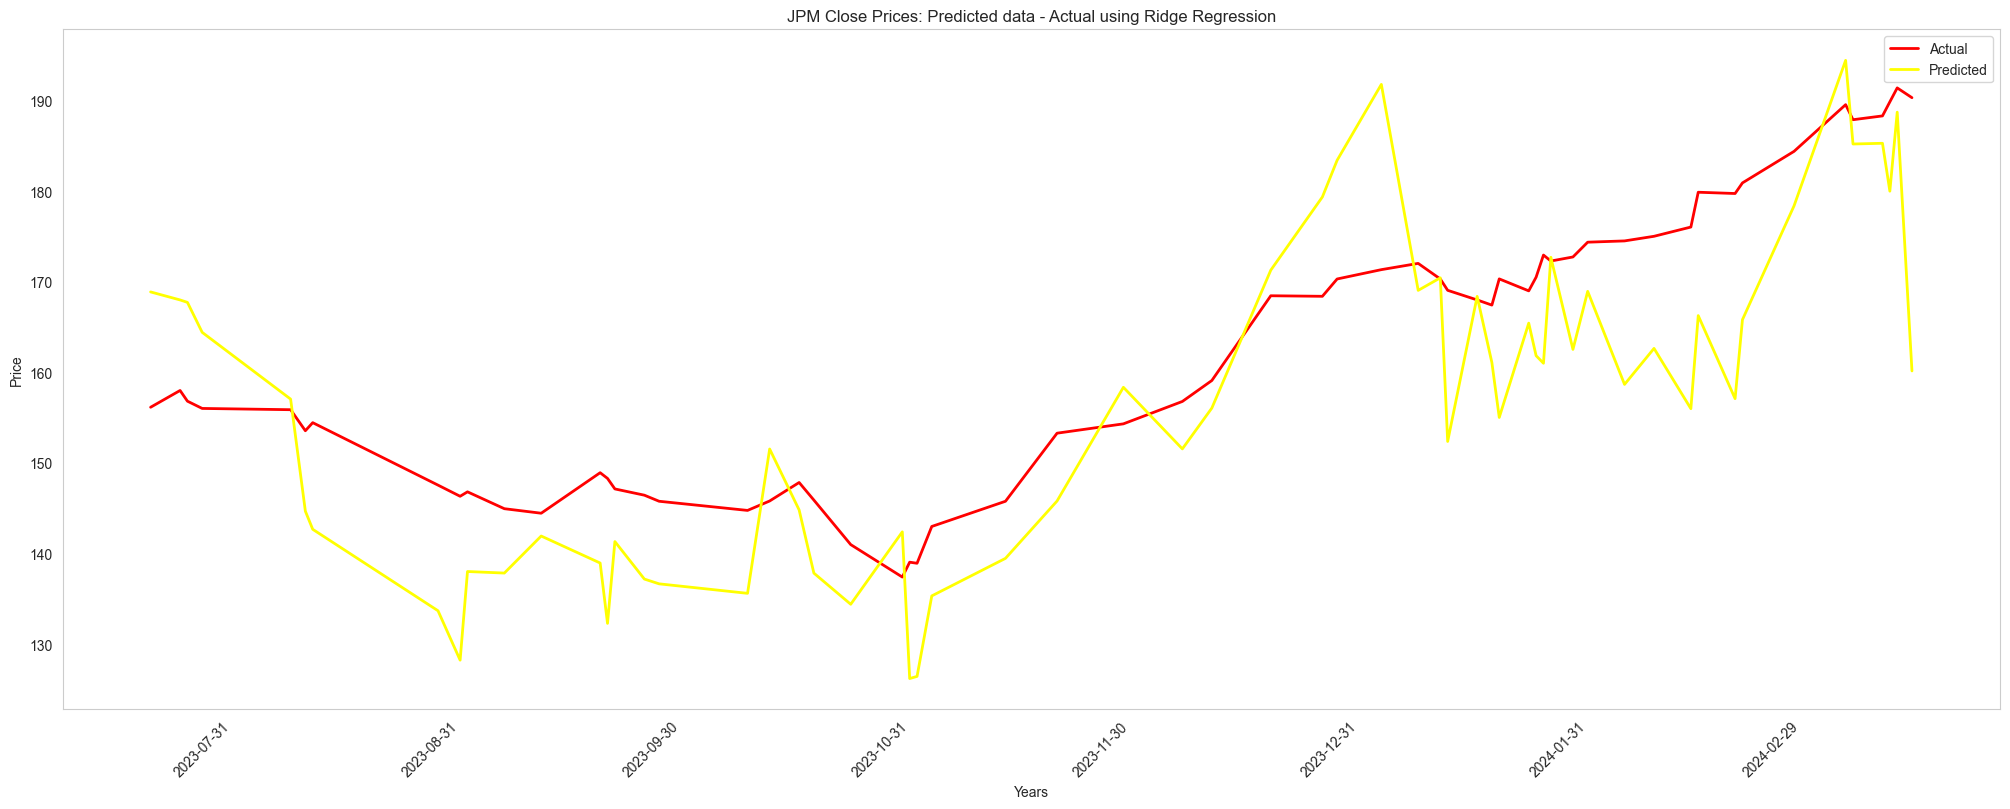

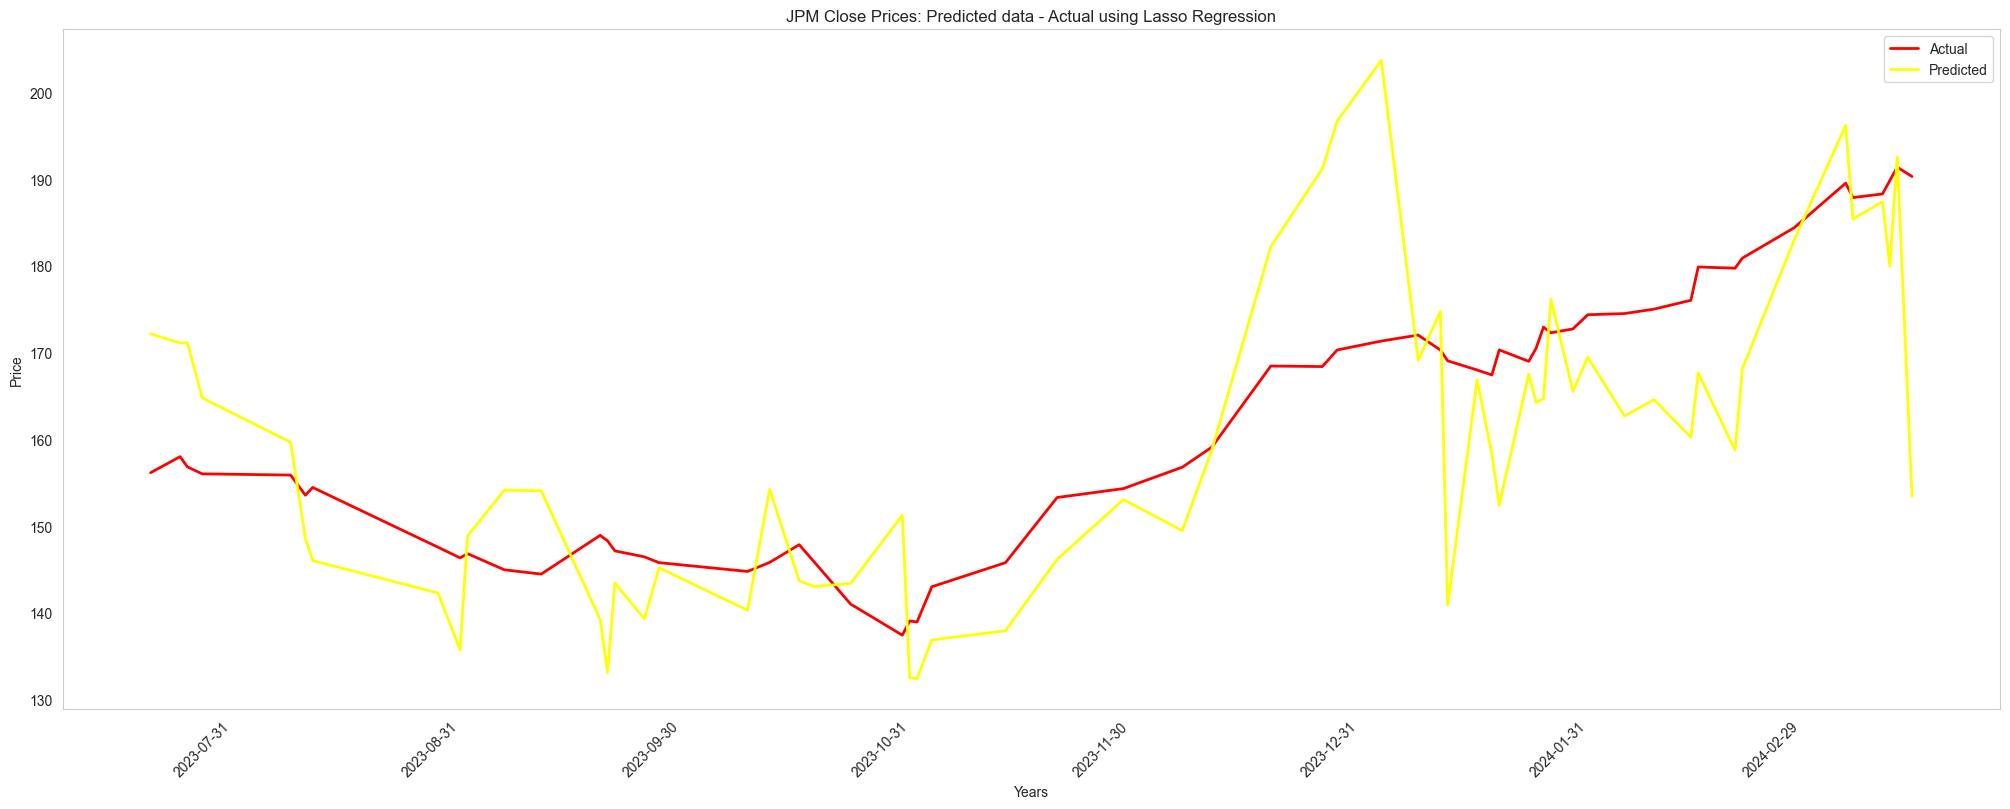

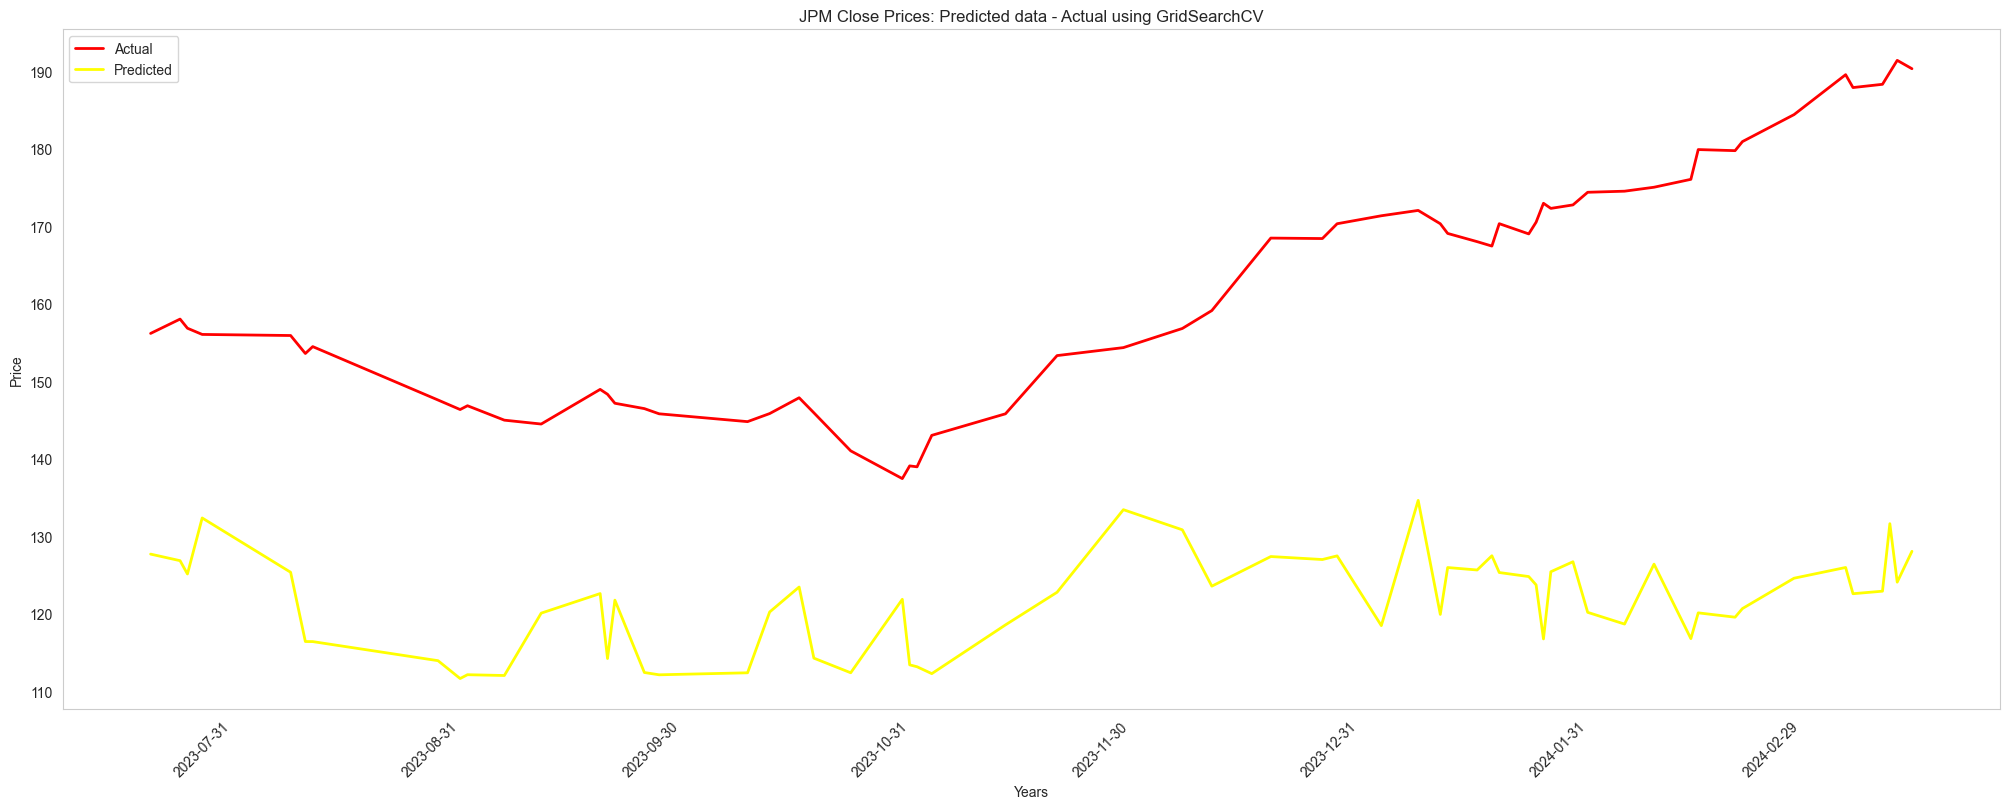

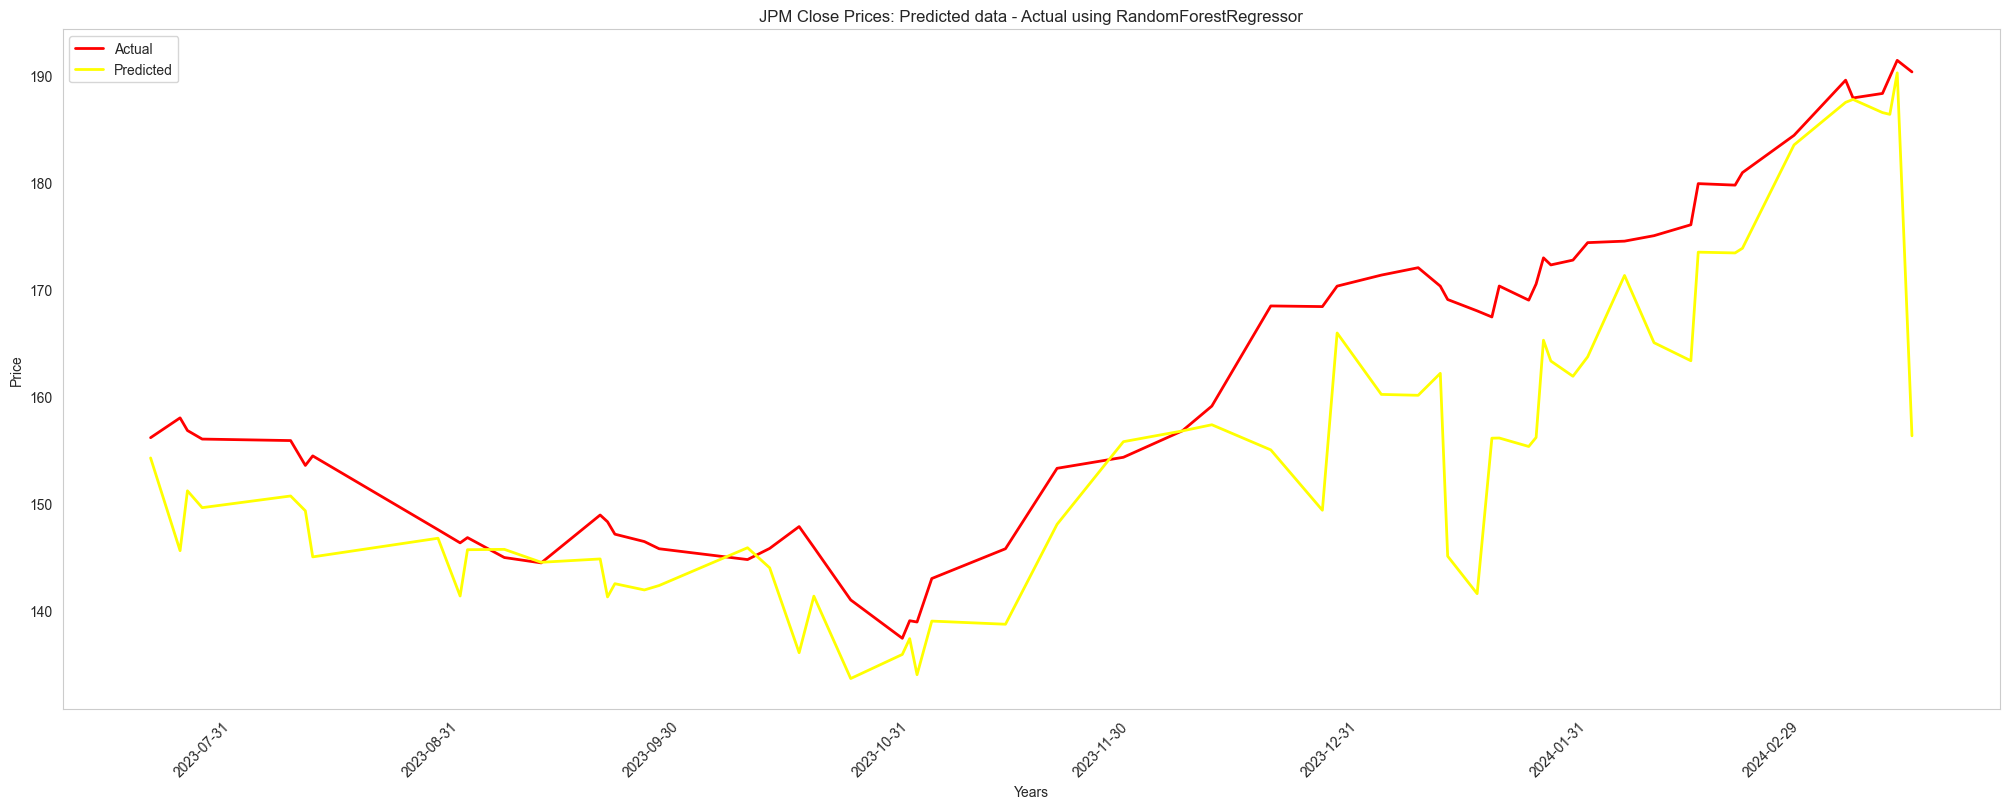

In [342]:
regression_models = {'Linear Regression': linreg,
                     'Ridge Regression': ridge1,
                     'Lasso Regression': lasso,
                     'GridSearchCV': grid_search,
                     'RandomForestRegressor': rfr
                     }
reg_model_metrics(regression_models, X_corr_train, X_corr_val, y_corr_train, y_corr_val)

In [343]:
print_permutation_importance([(linreg,'linreg'), (ridge1,'ridgereg'), (lasso,'lasso_reg'), (grid_search, 'clf'), (rfr,'rfr')], X_corr_val, y_corr_val, df_corr, X_corr)

Permutation importance to Close for LinearRegression
TRIX_20_period_TRIX22.867 +/- 2.453
EV_MACD_MACD      20.265 +/- 6.393
EV_MACD_SIGNAL    19.283 +/- 5.502
MACD_MACD         14.318 +/- 2.129
PPO_PPO           7.008 +/- 0.684
PPO_HISTO         2.238 +/- 0.400
trade_count       1.839 +/- 0.326
volume            1.342 +/- 0.072
MOM_MOM           1.232 +/- 0.164
RSI_14_period_RSI 1.124 +/- 0.135
HL_PCT            0.148 +/- 0.025
news_score        0.136 +/- 0.281
ROC_ROC           0.111 +/- 0.019
IFT_RSI_IFT_RSI   0.079 +/- 0.017
ER_10_period_ER   0.065 +/- 0.013
PCT_change        0.010 +/- 0.005
news_type         -0.009 +/- 0.007
 
Permutation importance to Close for RidgeCV
PPO_PPO           2.377 +/- 0.143
MACD_MACD         2.053 +/- 0.099
trade_count       1.404 +/- 0.129
volume            1.068 +/- 0.056
EV_MACD_MACD      0.901 +/- 0.084
EV_MACD_SIGNAL    0.722 +/- 0.103
TRIX_20_period_TRIX0.624 +/- 0.054
PPO_HISTO         0.429 +/- 0.036
MOM_MOM           0.161 +/- 0.026
ROC_ROC   

### Univariate Time Series Forecasting with LSTMs in Keras

We obtain historical data for 2016-2024 from Yahoo for ^GSPC symbol of SP500 index

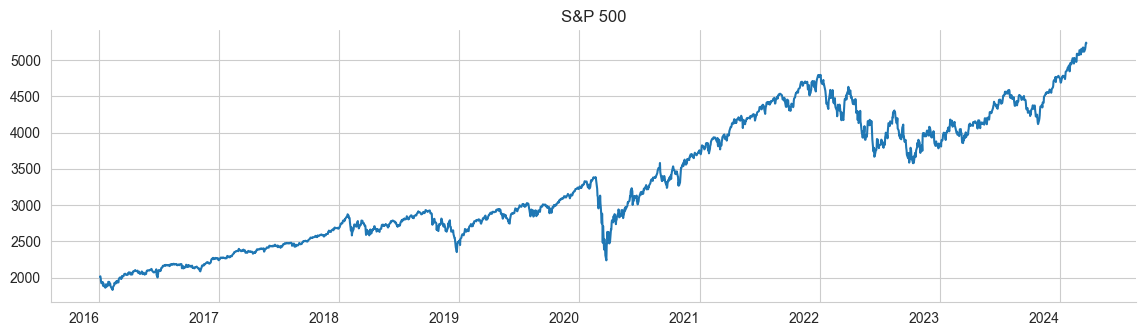

In [344]:
df = pd.read_csv('data/sp500_bars_2024-3-22.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
sp500 = df[['close']].copy()
sp500.rename(columns={'close': 'SP500'}, inplace=True)
ax = sp500.plot(title='S&P 500',
                legend=False,
                figsize=(14, 4),
                rot=0)
ax.set_xlabel('')
sns.despine()

#### Preprocessing

In [345]:
scaler = MinMaxScaler()

In [346]:
sp500_scaled = pd.Series(scaler.fit_transform(sp500).squeeze(), index=sp500.index)
sp500_scaled.describe()

count    2069.000000
mean        0.432834
std         0.254602
min         0.000000
25%         0.227224
50%         0.362646
75%         0.674357
max         1.000000
dtype: float64

#### Generating recurrent sequences from our time series

We will generate sequences of 63 trading days, approximately three months, and use a single LSTM layer with 20 hidden units to predict the index value one timestep ahead.
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

In [347]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

We apply this function to the rescaled stock index for a window_size=63 to obtain a two-dimensional dataset of shape number of samples x number of timesteps:

In [348]:
window_size = 63

In [349]:
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)

In [350]:
X.head()

0         1         2         3         4         5   \
date                                                                     
2016-04-05  0.053797  0.054984  0.047233  0.033410  0.027239  0.027719   
2016-04-06  0.054984  0.047233  0.033410  0.027239  0.027719  0.032118   
2016-04-07  0.047233  0.033410  0.027239  0.027719  0.032118  0.017934   
2016-04-08  0.033410  0.027239  0.027719  0.032118  0.017934  0.027183   
2016-04-11  0.027239  0.027719  0.032118  0.017934  0.027183  0.015019   

                  6         7         8         9   ...        53        54  \
date                                                ...                       
2016-04-05  0.032118  0.017934  0.027183  0.015019  ...  0.065208  0.064681   
2016-04-06  0.017934  0.027183  0.015019  0.015312  ...  0.064681  0.060845   
2016-04-07  0.027183  0.015019  0.015312  0.008865  ...  0.060845  0.060619   
2016-04-08  0.015019  0.015312  0.008865  0.011695  ...  0.060619  0.060945   
2016-04-11  0.015312  0.008865  0.011695  0.022805  ...  0.060945  0.066208   

                  55        56        57        58        59        60  \
date                                                                     
2016-04-05  0.060845  0.060619  0.060945  0.066208  0.068827  0.067594   
2016-04-06  0.060619  0.060945  0.066208  0.068827  0.067594  0.071415   
2016-04-07  0.060945  0.066208  0.068827  0.067594  0.071415  0.069466   
2016-04-08  0.066208  0.068827  0.067594  0.071415  0.069466  0.063324   
2016-04-11  0.068827  0.067594  0.071415  0.069466  0.063324  0.069622   

                  61        62  
date                            
2016-04-05  0.071415  0.069466  
2016-04-06  0.069466  0.063324  
2016-04-07  0.063324  0.069622  
2016-04-08  0.069622  0.062369  
2016-04-11  0.062369  0.064036  

[5 rows x 63 columns]

In [351]:
y.head()

date
2016-04-05    0.063324
2016-04-06    0.069622
2016-04-07    0.062369
2016-04-08    0.064036
2016-04-11    0.062392
dtype: float64

In [352]:
X.shape

(2006, 63)

#### Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2024.

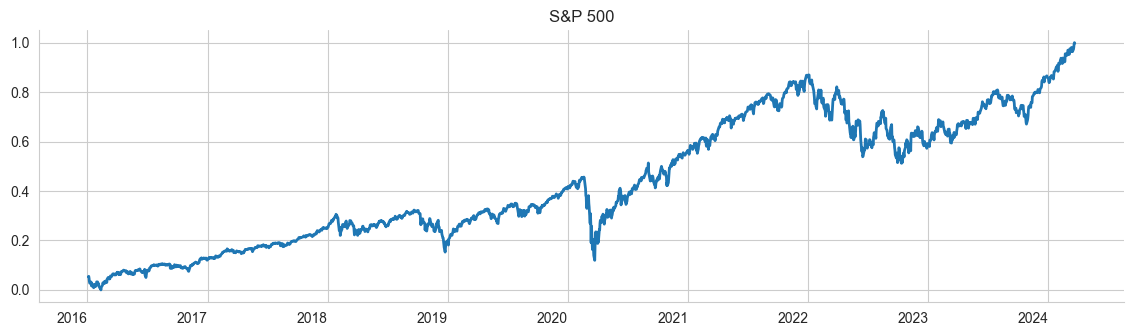

In [353]:
ax = sp500_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
ax.set_title('S&P 500')
sns.despine()

In [354]:
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

# keep the last year for testing
X_test = X['2023'].values.reshape(-1, window_size, 1)
y_test = y['2023']

In [355]:
n_obs, window_size, n_features = X_train.shape

In [356]:
y_train.shape

(1699,)

#### Keras LSTM Layer

Keras has several built-in RNN layers with various configuration options described in detail in the [documentation](https://keras.io/layers/recurrent/).

```
LSTM(units,
     activation='tanh',
     recurrent_activation='hard_sigmoid',
     use_bias=True,
     kernel_initializer='glorot_uniform',
     recurrent_initializer='orthogonal',
     bias_initializer='zeros',
     unit_forget_bias=True,
     kernel_regularizer=None,
     recurrent_regularizer=None,
     bias_regularizer=None,
     activity_regularizer=None,
     kernel_constraint=None,
     recurrent_constraint=None,
     bias_constraint=None,
     dropout=0.0,
     recurrent_dropout=0.0,
     implementation=1,
     return_sequences=False,
     return_state=False,
     go_backwards=False,
     stateful=False,
     unroll=False)
```

####  Define the Model Architecture

####  Define the Model Architecture

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 20 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

In [357]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

The summary shows that the model has 491 parameters:

In [358]:
rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

#### Train the Model

We train the model using the RMSProp optimizer recommended for RNN with default settings and compile the model with mean squared error for this regression problem:

In [359]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     weight_decay=0.0)

In [360]:
rnn.compile(loss='mean_squared_error', optimizer=optimizer)

We define an EarlyStopping callback and train the model for up to 100 episodes. 

In [361]:
rnn_path = ('data/rnn.keras')
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [362]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=20,
                               restore_best_weights=True)

In [363]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0750
Epoch 1: val_loss improved from inf to 0.00062, saving model to data/rnn.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0739 - val_loss: 6.2064e-04
Epoch 2/150
82/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.9237e-04
Epoch 2: val_loss did not improve from 0.00062
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.9081e-04 - val_loss: 9.1761e-04
Epoch 3/150
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5004e-04
Epoch 3: val_loss improved from 0.00062 to 0.00052, saving model to data/rnn.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.5223e-04 - val_loss: 5.1920e-04
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7645e-04
Epoch 4: val_loss did not improve from 0.00052
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7682e-04 - val_loss: 9.3734e-04
Epoch 5/150
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.0966e-04
Epoch 5: val_loss did not improve from 0.00052
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8

Training stops after 125 epochs; the `early_stopping` callback restores the weights for the best model (after 85 epochs)

#### Evaluate model performance

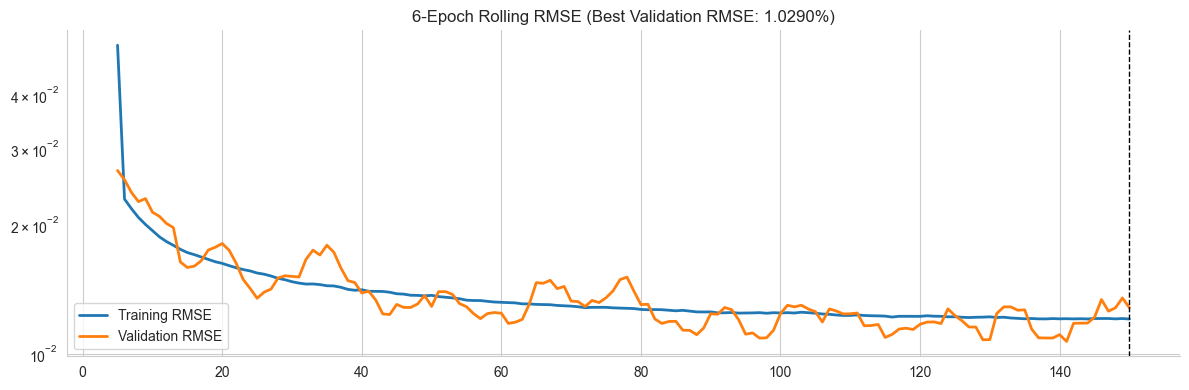

In [364]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'6-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig('images/rnn_sp500_error', dpi=300);

In [365]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0115 | Test RMSE: 0.0103


In [366]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [367]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9981 | Test IC: 0.9837


#### Rescale predictions

In [368]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [369]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [370]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 39.02 | Test RMSE: 35.31'

In [371]:
sp500['Train Predictions'] = train_predict
sp500['Test Predictions'] = test_predict
sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train').append(test_predict.to_frame('predictions').assign(data='Test')))

#### Plot Results

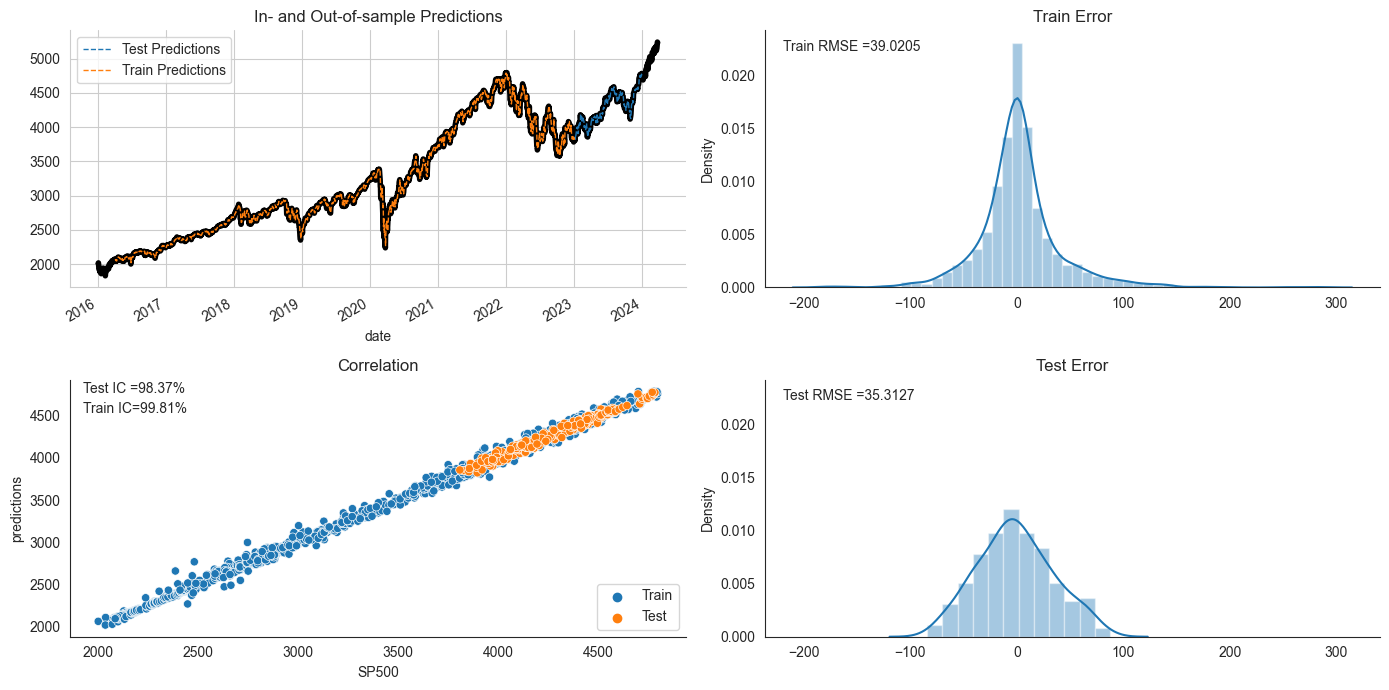

In [372]:
fig = plt.figure(figsize=(14, 7))
ax1 = plt.subplot(221)

sp500.loc['2016':, 'SP500'].plot(lw=4, ax=ax1, c='k')
sp500.loc['2016':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex=ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze() - y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze() - y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig('images/rnn_sp500_regression', dpi=300);


### Multivariate Time Series Forecasting with LSTMs in Keras

Multivariate time-series models are designed to capture the dynamic of
multiple time series simultaneously and leverage dependencies across these
series for more reliable predictions.
At this case, we are going to use the VWAP and CLOSE data features as time-series of JPM stock for the past 7 years.

### Load Data

In [373]:
df_stocks.head(3)

open    high    low  close      volume  trade_count       vwap  \
date                                                                          
2016-01-04  63.95  64.060  63.01  63.62  27827227.0     145804.0  63.451452   
2016-01-05  63.69  64.130  63.04  63.73  17591872.0     103027.0  63.519312   
2016-01-06  62.70  63.125  62.34  62.81  24407202.0     124497.0  62.745693   

              HL_PCT  PCT_change  
date                              
2016-01-04  1.650424   -0.516028  
2016-01-05  1.710340    0.062804  
2016-01-06  1.249801    0.175439

In [374]:
df_stocks.tail(3)

open    high     low   close      volume  trade_count  \
date                                                                  
2024-03-20  194.19  196.56  193.61  196.33   9367043.0     129684.0   
2024-03-21  196.52  199.43  196.33  199.06  11203796.0     139164.0   
2024-03-22  199.01  200.48  196.54  196.62   8108840.0     109826.0   

                  vwap    HL_PCT  PCT_change  
date                                          
2024-03-20  195.617114  1.502572    1.102013  
2024-03-21  198.685277  1.557319    1.292489  
2024-03-22  197.522578  2.003865   -1.200945

In [375]:
df = df_stocks[['vwap', 'close']].iloc[11:,:]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2058 entries, 2016-01-20 to 2024-03-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vwap    2058 non-null   float64
 1   close   2058 non-null   float64
dtypes: float64(2)
memory usage: 48.2 KB


In [376]:
df.tail()

vwap   close
date                          
2024-03-18  192.015808  192.66
2024-03-19  193.471047  193.79
2024-03-20  195.617114  196.33
2024-03-21  198.685277  199.06
2024-03-22  197.522578  196.62

In [377]:
df.shape

(2058, 2)

### Prepare Data

### Stationarity

We apply the following transformation, annual difference for both series, prior log-transform to achieve stationarity on Time Series Models:

In [378]:
df_transformed = (pd.DataFrame({'vwap': np.log(df.vwap).diff(21), 'close': df.close.diff(21)}).dropna())

### Scaling

Then we scale the transformed data to the [0,1] interval:

In [379]:
df_transformed = df_transformed.apply(minmax_scale)

### Plot original and transformed series

In [380]:
sns.set_style('whitegrid')
np.random.seed(42)

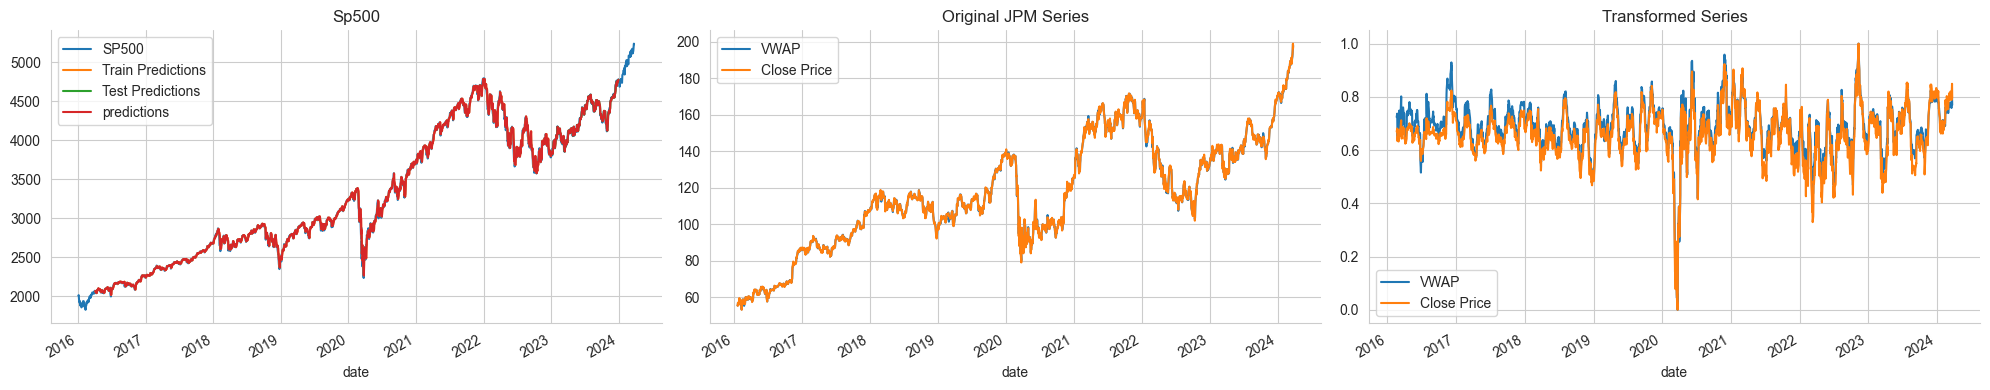

In [381]:
fig, axes = plt.subplots(ncols=3, figsize=(20,4))
sp500.plot(ax=axes[0], title='Sp500')
columns={'vwap': 'VWAP', 'close': 'Close Price'}
df.rename(columns=columns).plot(ax=axes[1], title='Original JPM Series')
df_transformed.rename(columns=columns).plot(ax=axes[2], title='Transformed Series')
sns.despine()
fig.tight_layout()
fig.savefig('images/multi_rnn', dpi=300)

### Reshape data into RNN format

We can reshape directly to get non-overlapping series, i.e., one sample for each year (works only if the number of samples is divisible by window size):

In [382]:
df.values.reshape(-1, 21, 2).shape

(98, 21, 2)

However, we want rolling, not non-overlapping lagged values. The create_multivariate_rnn_data function transforms a dataset of several time series into the shape required by the Keras RNN layers, namely `n_samples` x `window_size` x `n_series`, as follows:

In [383]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j]
                  for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

We will use window_size of 24 months and obtain the desired inputs for our RNN model, as follows:

In [384]:
window_size = 24

In [385]:
X, y = create_multivariate_rnn_data(df_transformed, window_size=window_size)

Finally, we split our data into a train and a test set, using the last 24 months to test the out-of-sample performance, as shown here:

In [386]:
test_size =520
train_size = X.shape[0]-test_size

In [387]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

### Define Model Architecture

We use a similar architecture with two stacked LSTM layers with 30 and 15 units, respectively, followed by a fully-connected layer with 10 units. The output layer has two units, one for each time series. We compile them using mean absolute loss and the recommended RMSProp optimizer, as follows:

In [388]:
K.clear_session()

In [389]:
n_features = output_size = 2

In [390]:
lstm_units = 20
dense_units = 10

In [391]:
rnn = Sequential([layers.Input((window_size, n_features)),
                  layers.LSTM(lstm_units, return_sequences=False, recurrent_dropout=0.1),
                  layers.Dense(dense_units, activation='relu'),
                  layers.Dense(dense_units, activation='relu'),
                  layers.Dropout(0.1),
                  layers.Dense(output_size),
                  layers.Activation('linear')
                  ])

The model has 2,182 parameters, as shown here:

In [392]:
rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20)             │         1,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            22 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,182 (8.52 KB)

 Trainable params: 2,182 (8.52 KB)

 Non-trainable params: 0 (0.00 B)

In [393]:
rnn.compile(loss='mae', optimizer=SGD(learning_rate=0.01))

## Train the Model

We train for 100 epochs with a batch_size value of 20 using early stopping:

In [394]:
lstm_path = f'data\lstm.keras'

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [395]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True)

In [396]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=20,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping, checkpointer],
                 verbose=1)

Epoch 1/100
65/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6172
Epoch 1: val_loss improved from inf to 0.29203, saving model to data\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6013 - val_loss: 0.2920
Epoch 2/100
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2142
Epoch 2: val_loss improved from 0.29203 to 0.08227, saving model to data\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2125 - val_loss: 0.0823
Epoch 3/100
66/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513
Epoch 3: val_loss improved from 0.08227 to 0.08171, saving model to data\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0529 - val_loss: 0.0817
Epoch 4/100
62/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0489
Epoch 4: val_loss improved from 0.08171 to 0.08046, saving model to data\lstm.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0514 - val_loss: 0.0805
Epoch 5/100
62/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479
Epoch 5: val_loss did not improve from 0.08046

### Evaluate the Results

Training stops early after 77 epochs, yielding a test MAE of 0.0366

The RNN model produces 24 months one-step-ahead forecasts

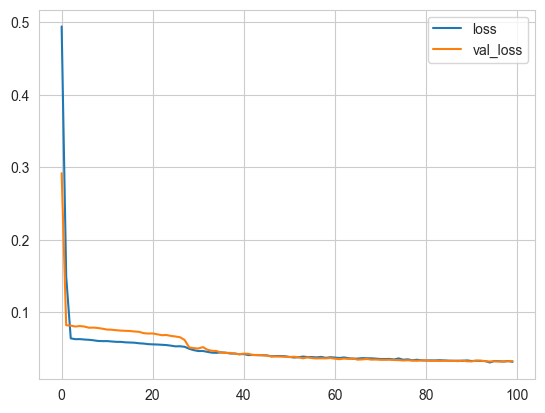

In [397]:
pd.DataFrame(result.history).plot();

In [398]:
y_pred = pd.DataFrame(rnn.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred.info()

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 520 entries, 2022-02-28 to 2024-03-22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   vwap    520 non-null    float32
 1   close   520 non-null    float32
dtypes: float32(2)
memory usage: 8.1 KB


In [399]:
test_mae = mean_absolute_error(y_pred, y_test)
print(test_mae)

0.03219386778571946


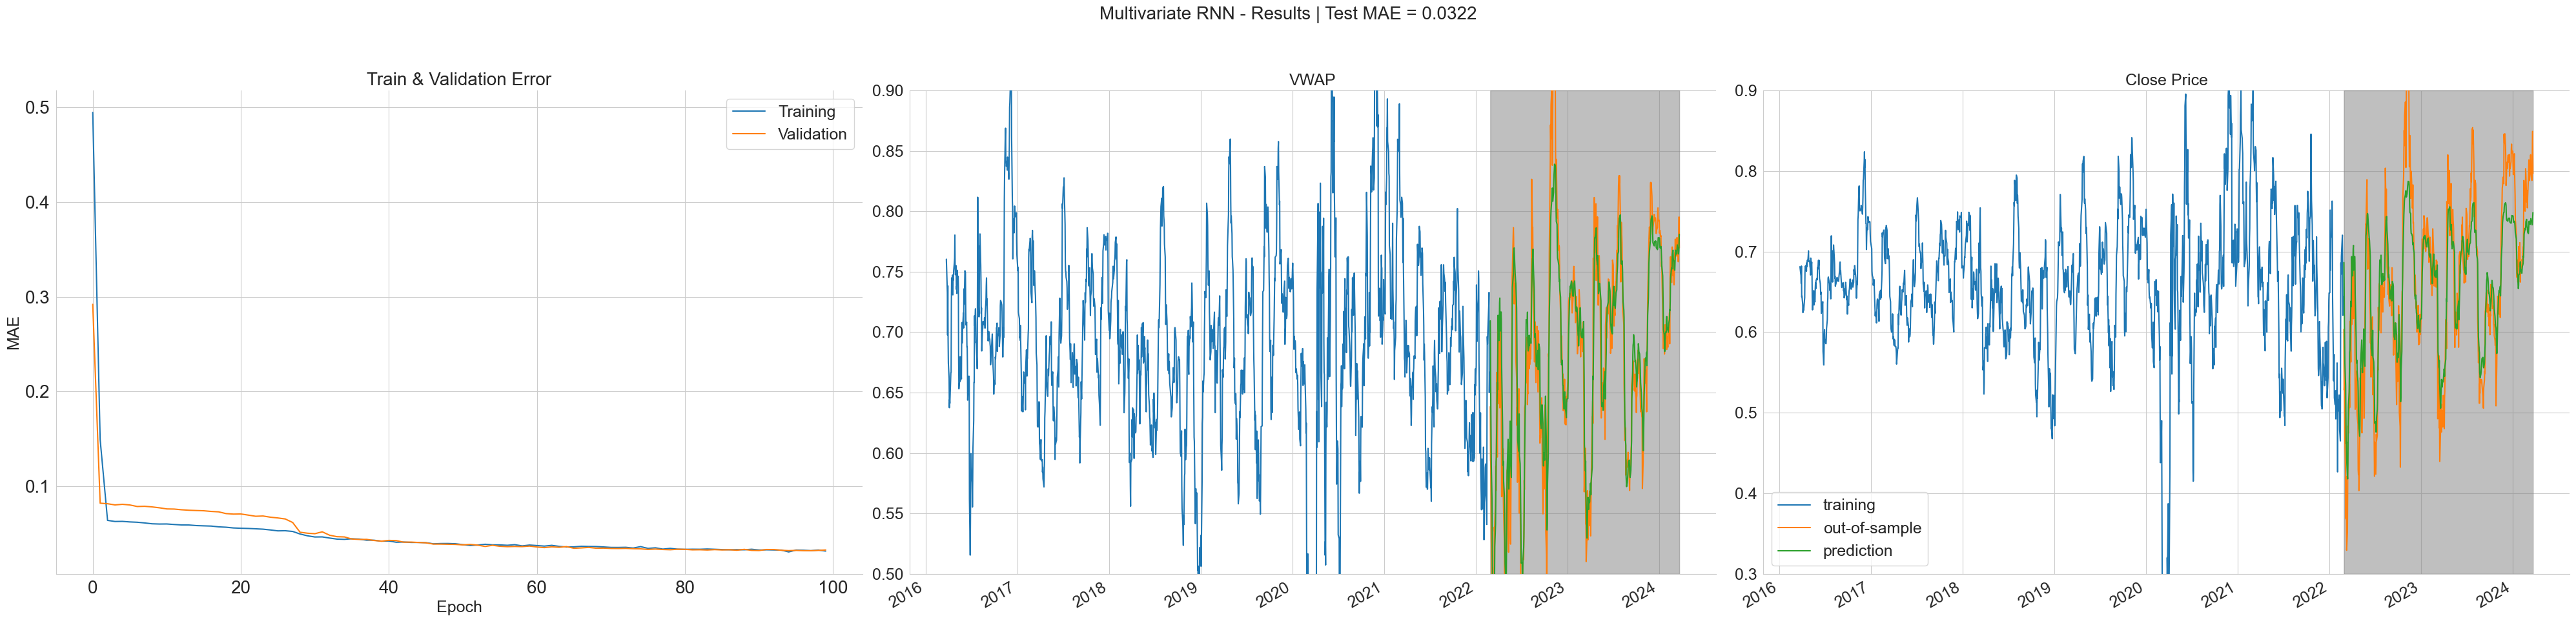

In [400]:
fig, axes = plt.subplots(ncols=3, figsize=(40, 10))
pd.DataFrame(result.history).rename(columns={'loss': 'Training', 'val_loss': 'Validation'}).plot(ax=axes[0], fontsize='20')
axes[0].set_xlabel('Epoch', fontsize=18)
axes[0].set_ylabel('MAE', fontsize=18)
axes[0].legend(fontsize=18)
axes[0].set_title('Train & Validation Error', fontsize='20')
col_dict = {'vwap': 'VWAP', 'close': 'Close Price'}

for i, col in enumerate(y_test.columns, 1):
    y_train.loc['2016':, col].plot(ax=axes[i], label='training', title=col_dict[col], fontsize=18)
    y_test[col].plot(ax=axes[i], label='out-of-sample', fontsize=18)
    y_pred[col].plot(ax=axes[i], label='prediction', fontsize=18)
    axes[i].set_xlabel(' ', fontsize=18)
    axes[i].set_title('VWAP', fontsize=18) if i == 1 else axes[i].set_title('Close Price', fontsize=18)

axes[1].set_ylim(.5, .9)
axes[1].fill_between(x=y_test.index, y1=0.5, y2=0.9, color='grey', alpha=.5)

axes[2].set_ylim(.3, .9)
axes[2].fill_between(x=y_test.index, y1=0.3, y2=0.9, color='grey', alpha=.5)

plt.legend(fontsize=18)
fig.suptitle('Multivariate RNN - Results | Test MAE = {:.4f}'.format(test_mae), fontsize=20)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig('images/multivariate_results', dpi=300);

### Forcasting Next day Price for the Stock

In [401]:
df_lstm = df_stocks[['vwap', 'high', 'low', 'close']].copy()

In [402]:
df_lstm.head()

vwap    high    low  close
date                                       
2016-01-04  63.451452  64.060  63.01  63.62
2016-01-05  63.519312  64.130  63.04  63.73
2016-01-06  62.745693  63.125  62.34  62.81
2016-01-07  60.834008  62.000  60.08  60.27
2016-01-08  59.791316  61.270  58.85  58.92

In [403]:
df_lstm.tail()

vwap    high     low   close
date                                          
2024-03-18  192.015808  192.70  189.89  192.66
2024-03-19  193.471047  193.93  192.38  193.79
2024-03-20  195.617114  196.56  193.61  196.33
2024-03-21  198.685277  199.43  196.33  199.06
2024-03-22  197.522578  200.48  196.54  196.62

In [404]:
df_lstm.shape

(2069, 4)

In [405]:
# Creating own index for flexibility
obs = np.arange(1, len(df_lstm) + 1, 1)

In [406]:
# Taking different indicators for prediction
HLC_avg = df_lstm[['high', 'low', 'close']].mean(axis=1)
VWAP_avg = df_lstm[['vwap']]
close_val = df_lstm[['close']]

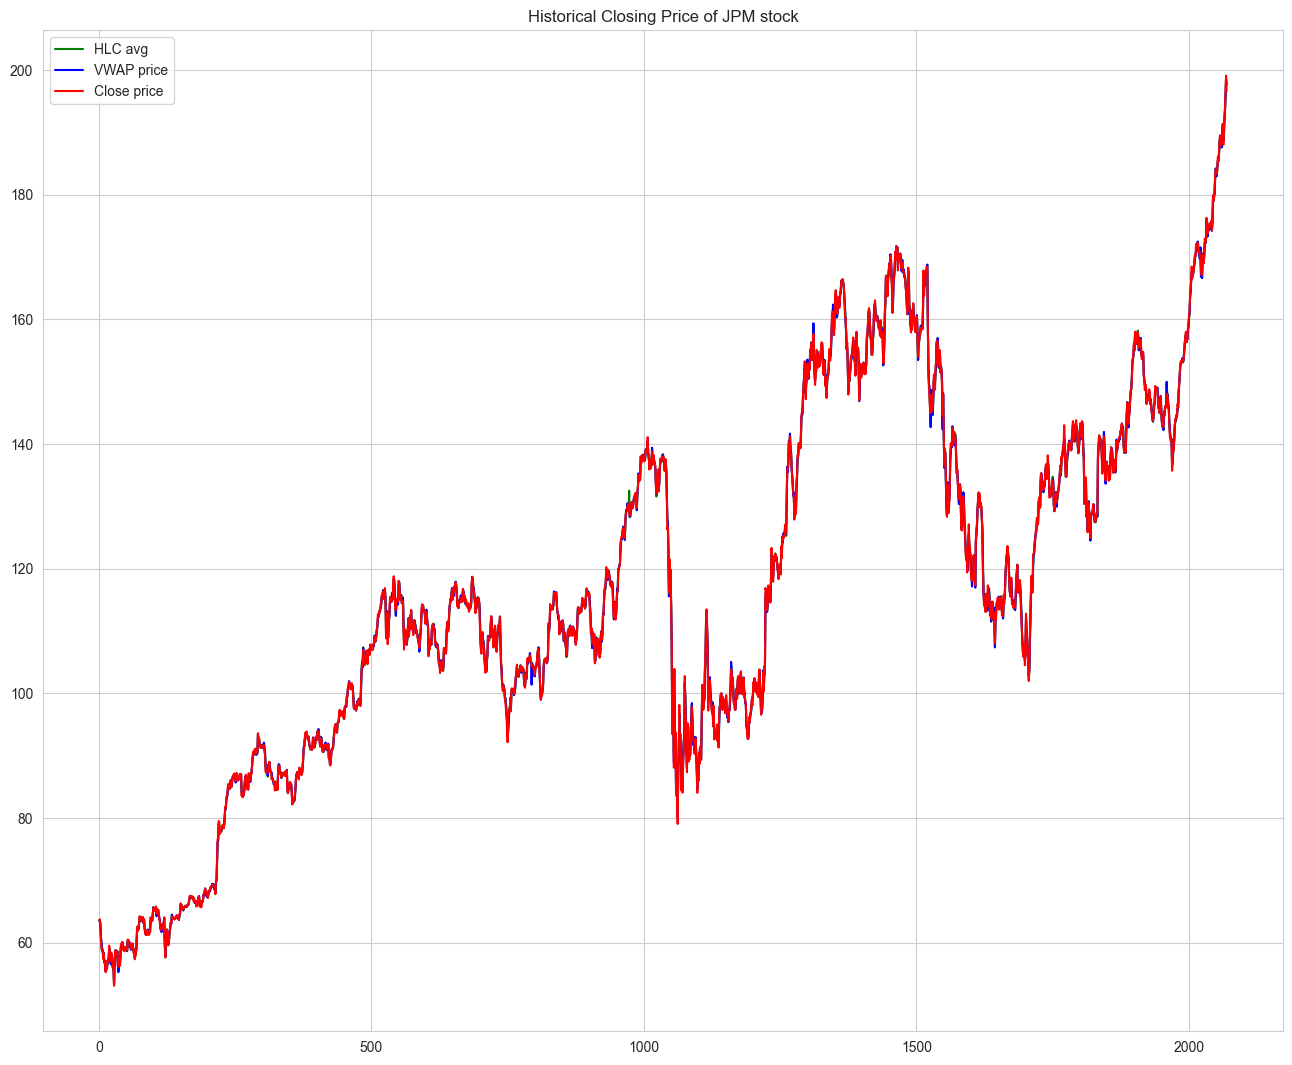

In [407]:
plt.figure(figsize=(16, 13))
plt.plot(obs, HLC_avg, 'g', label='HLC avg')
plt.plot(obs, VWAP_avg, 'b', label='VWAP price')
plt.plot(obs, close_val, 'r', label='Close price')
plt.title('Historical Closing Price of JPM stock')
plt.legend(loc='upper left')
plt.show()

as the HLC avg prices are so close to VWAP prices, we are going to use only VWAP to predict the CLOSE prices 

In [408]:
# Reshaping of the dataset util
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        a = dataset[i:(i + step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [409]:
# Preparation of time series dataset
VWAP_avg = np.reshape(VWAP_avg.values, (len(VWAP_avg), 1))  # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
VWAP_avg = scaler.fit_transform(VWAP_avg)

In [410]:
# Train-Test split
train_VWAP = int(len(VWAP_avg) * 0.75)
test_VWAP = len(VWAP_avg) - train_VWAP
train_VWAP, test_VWAP = VWAP_avg[0:train_VWAP, :], VWAP_avg[train_VWAP:len(VWAP_avg), :]

In [411]:
# Time-Series dataset (for time T, values for time T+1)
X_train, y_train = new_dataset(train_VWAP, 1)
X_test, y_test = new_dataset(test_VWAP, 1)

In [412]:
# Reshaping Training and Test dataset
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
step_size = 1

#### LSTM Model

In [413]:
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
lstm_model.add(LSTM(16))
lstm_model.add(Dropout(0.25))
lstm_model.add(Dense(1))
lstm_model.add(Activation('linear'))

In [414]:
# Model compiling and training
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])  # Try SGD, adam, adagrad and compare!!!
lstm_model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
1549/1549 - 3s - 2ms/step - accuracy: 6.4558e-04 - loss: 0.0160 - val_accuracy: 0.0019 - val_loss: 0.0014
Epoch 2/5
1549/1549 - 2s - 1ms/step - accuracy: 6.4558e-04 - loss: 0.0028 - val_accuracy: 0.0019 - val_loss: 3.0764e-04
Epoch 3/5
1549/1549 - 1s - 925us/step - accuracy: 6.4558e-04 - loss: 0.0018 - val_accuracy: 0.0019 - val_loss: 2.2263e-04
Epoch 4/5
1549/1549 - 1s - 916us/step - accuracy: 6.4558e-04 - loss: 0.0014 - val_accuracy: 0.0019 - val_loss: 7.4688e-04
Epoch 5/5
1549/1549 - 1s - 900us/step - accuracy: 6.4558e-04 - loss: 0.0012 - val_accuracy: 0.0019 - val_loss: 5.0588e-04


In [415]:
# Prediction
trainPredict = lstm_model.predict(X_train)
testPredict = lstm_model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step


In [416]:
# De-Normalizing for plotting
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform([y_test])

In [417]:
# Training RMSE
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 2.93


In [418]:
# Test RMSE
testScore = math.sqrt(mean_squared_error(y_test[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 3.27


In [419]:
# Creating similar dataset to plot Training predictions 
trainPredictPlot = np.empty_like(VWAP_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict) + step_size, :] = trainPredict

In [420]:
# Creating similar dataset to plot Test predictions 
testPredictPlot = np.empty_like(VWAP_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (step_size * 2) + 1:len(VWAP_avg) - 1, :] = testPredict

In [421]:
# De-Normalizing Main dataset 
VWAP_avg = scaler.inverse_transform(VWAP_avg)

Plot of main OHLC values, Train predictions and Test predictions

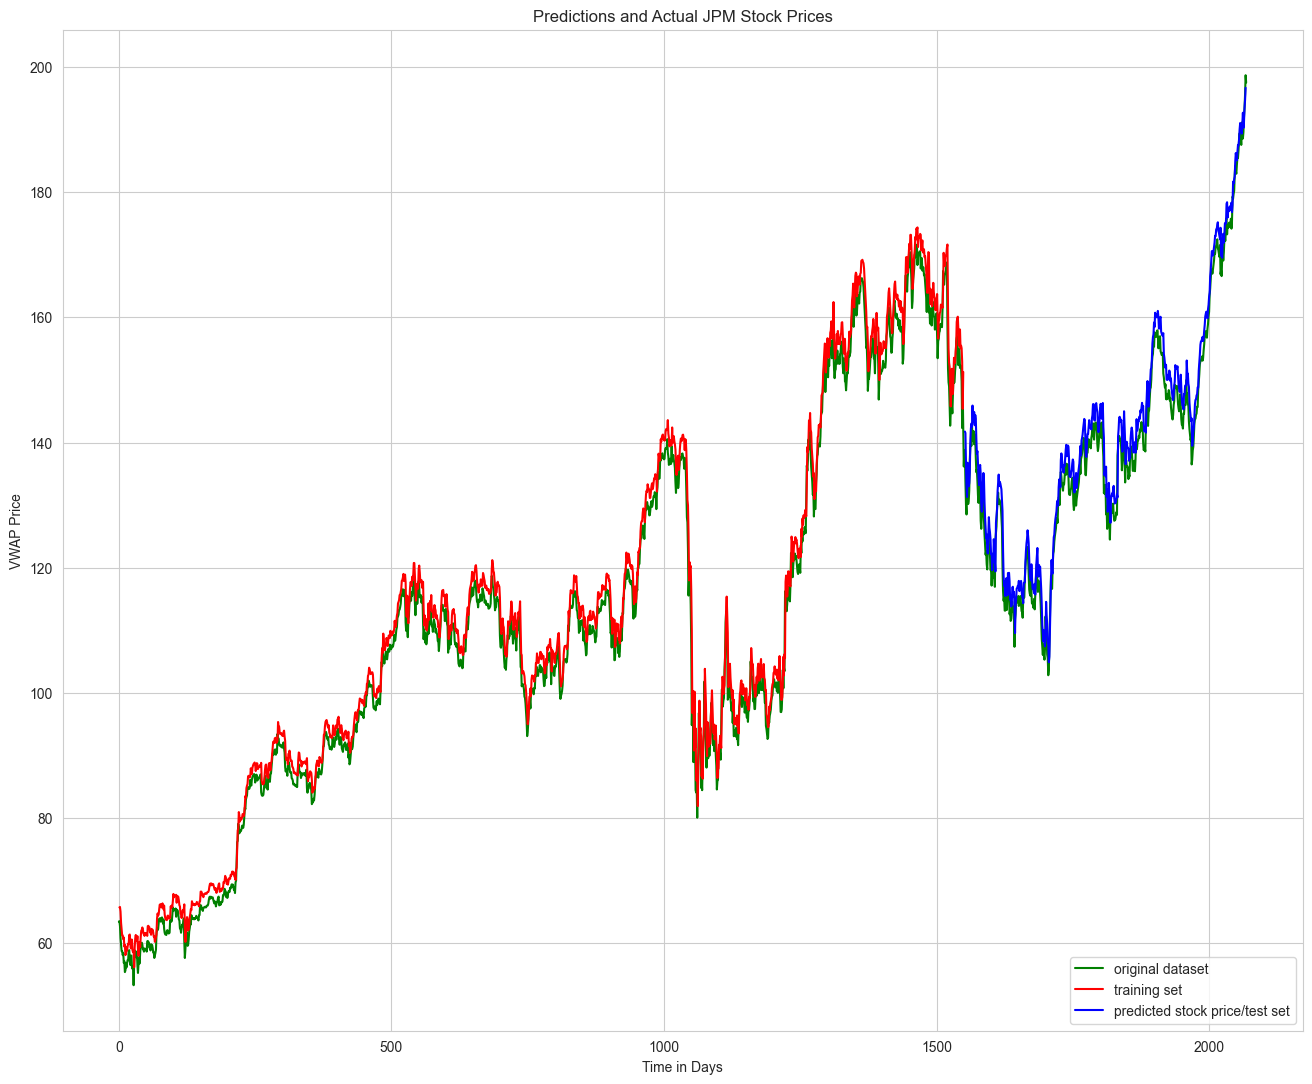

In [422]:
plt.figure(figsize=(16, 13))
plt.plot(VWAP_avg, 'g', label='original dataset')
plt.plot(trainPredictPlot, 'r', label='training set')
plt.plot(testPredictPlot, 'b', label='predicted stock price/test set')
plt.title('Predictions and Actual JPM Stock Prices', family='Arial', fontsize=12)
plt.legend(loc='lower right')
plt.xlabel('Time in Days')
plt.ylabel('VWAP Price')
plt.show()

#### Predicting Future Values

In [423]:
last_val = testPredict[-1]
last_val_scaled = last_val / last_val
next_val = lstm_model.predict(np.reshape(last_val_scaled, (1, 1, 1)))
print("Last Day Value:", np.ndarray.item(last_val))
print("Next Day Value:", np.ndarray.item(last_val * next_val))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Last Day Value: 196.670654296875
Next Day Value: 197.64736938476562
